# Customer Churn - C744 Perfomance Assessment

## Importing required libraries, Data Collection & Data Exploration

### 1. Importing Required Libraries

In [1]:
# Data processesing, CSV I/O 
import pandas as pd
import numpy as np

# Data Visualizations
import matplotlib as mt
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dx
import itertools
import warnings

# Data Pre-processing, Model Building and Assessments
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling

import statsmodels.api as sm # Stats model for ANOVA

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_auc_score,roc_curve

# For Tree visualization
from sklearn import tree
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import display

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### 2. Data Collection

In [2]:
# Notebook settings
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 100)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:

telecom = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
telecom.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [4]:

# Get the overview of data
telecom.info() 

## Obs: 
##  1. Out of all features, tenure, MonthlyCharges and TotalCharges looks like continuous variables. 
##        Need to explore more to decide type (categorical vs numerical) of each feature
##   1.1. Object type of TotalCharges is object. Need to change type to float for proper processing. 
##   1.2. SeniorCitizen is int64, but is a categorical feature (confirmed later by unique values)
##  2. 7043 observations and 21 features
##   2.1. 20 features (Predictor Variables) and 1 Dependent/Response variable - Churn -> 
##           since we need to predict finally if the customer would be retained or Churned based on features
## Need to check the individual statistics of the features and response variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Convert the type of TotalCharges & check for Missing Values
telecom["TotalCharges"] = telecom["TotalCharges"].apply(pd.to_numeric, downcast="float", errors="coerce")
telecom.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [6]:
# Fix Missing entries in TotalCharges
telecom["TotalCharges"] = telecom["TotalCharges"].apply(pd.to_numeric, downcast="float", errors="coerce").fillna(0)
telecom.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
telecom["SeniorCitizen"] = telecom.SeniorCitizen.astype("str")

In [8]:
telecom.mean()

SeniorCitizen             inf
tenure              32.371149
MonthlyCharges      64.761692
TotalCharges      2279.734304
dtype: float64

In [9]:
# List number of unique entries in each of the feature
telecom.nunique()

## Obs: It is confirmed that tenure, MonthlyCharges and TotalCharges are numeric/continuous variables
##      The customerID feature is an identifier columns for each observation, with unique value for each observation.
##      Remaining 17 variables are categorical in nature.

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [10]:
# List unique entries in each of the features
telecom_columns = telecom.columns.tolist()
telecom_columns

for i in telecom_columns:
    print(i, ": ", telecom[i].unique())

customerID :  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender :  ['Female' 'Male']
SeniorCitizen :  ['0' '1']
Partner :  ['Yes' 'No']
Dependents :  ['No' 'Yes']
tenure :  [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService :  ['No' 'Yes']
MultipleLines :  ['No phone service' 'No' 'Yes']
InternetService :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity :  ['No' 'Yes' 'No internet service']
OnlineBackup :  ['Yes' 'No' 'No internet service']
DeviceProtection :  ['No' 'Yes' 'No internet service']
TechSupport :  ['No' 'Yes' 'No internet service']
StreamingTV :  ['No' 'Yes' 'No internet service']
StreamingMovies :  ['No' 'Yes' 'No internet service']
Contract :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling :  ['Yes' 'No']
PaymentMethod :  ['Electronic check' '

## Feature Engineering
##### Obs: Some categorical levels can be condensed to reduced the # of levels. e.g OnlineSecurity => No internet service - > can be converted to No

In [11]:
# Some categorical feature levels can be refined for a cleaner classification between catergory levels

# 1. Change "No internet service" to "No"
l_reduce_nointernet = ["OnlineSecurity", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", \
             "StreamingTV", "StreamingMovies"]

for cols in l_reduce_nointernet:
    telecom[cols] = telecom[cols].replace({"No internet service" : "No"})

# 2. Change "No phone service" to "No"
telecom["MultipleLines"] = telecom["MultipleLines"].replace({"No phone service": "No"})

# 3. Shorten PaymentMethod details
telecom["PaymentMethod"] = telecom["PaymentMethod"].replace({"Electronic check": "ECheck",
                                                             "Mailed check":"MCheck",
                                                             "Bank transfer (automatic)":"AutoBankTransfer",
                                                             "Credit card (automatic)":"AutoCreditCard"})

# 4. Shorten InternetService details
telecom["InternetService"] = telecom["InternetService"].replace({"Fiber optic" :"FiberOptic"})

#5. Shorten Contract details
telecom["Contract"] = telecom["Contract"].replace({"Month-to-month" :"Monthly", "One year":"1yr", "Two year":"2yr"})

In [12]:

# Convert Tenure into categorical feature levels
def tenure_conversion(df):
    if df["tenure"] <= 12:
        return "t_0-1"
    if (df["tenure"] > 12) & (df["tenure"] <= 24):
        return "t_1-2"
    if (df["tenure"] > 24) & (df["tenure"] <= 48):
        return "t_2-4"
    if (df["tenure"] > 48) & (df["tenure"] <= 60):
        return "t_4-5"
    if df["tenure"] > 60:
        return "t_5plus"
telecom["tenuregroup"] = telecom.apply(lambda x: tenure_conversion(x), axis=1)

In [14]:
# 1. Since converted to groups, tenure can be dropped
# 2. Since Customer ID is not adding any value to the analysis, it can be dropped 
telecom = telecom.drop(columns=["tenure", "customerID"],axis=1) 

In [15]:
# Check for Null values again to make sure all obersvations are okay
telecom.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
tenuregroup         0
dtype: int64

## Get Summary Statistics of the Data

In [16]:
#Get summary stats for all continious variables
telecom.describe() 

## Obs: 

MonthlyCharges  TotalCharges
count     7043.000000   7043.000000
mean        64.761692   2279.734304
std         30.090047   2266.794471
min         18.250000      0.000000
25%         35.500000    398.549988
50%         70.350000   1394.550049
75%         89.850000   3786.599976
max        118.750000   8684.799805

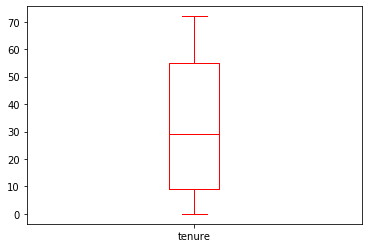

In [16]:
## Box-Plot to understand Outliers on continuous variables

# 1. Tenure
telecom["tenure"].plot(kind="box", color = "r")

## Obs: No Outliers

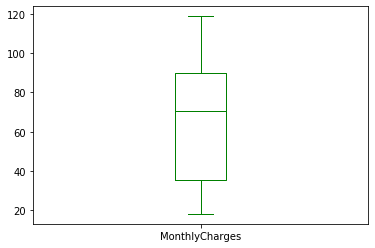

In [17]:
#2. MonthlyCharges
telecom["MonthlyCharges"].plot(kind="box", color = "g")

## Obs: No Outliers

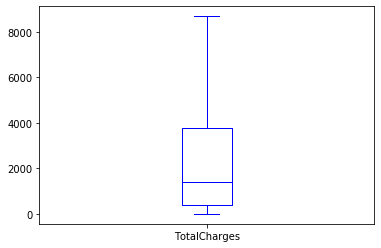

In [18]:
#3. TotalCharges
telecom["TotalCharges"].plot(kind="box", color = "b")

## Obs: No Outliers

## Check the summary & distribution of data

### Summary of Features & Response Variables

Percentage of Retained Customers: 73.46%
Percentage of Churn Customers: 26.54%


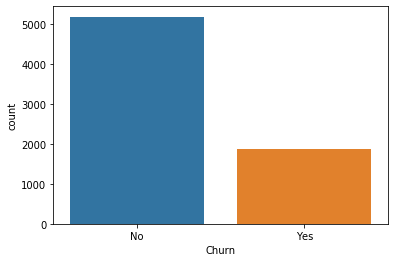

In [20]:
sns.countplot(data=telecom, x="Churn")


count_no = len(telecom[telecom["Churn"] == "No"])
count_yes = len(telecom[telecom["Churn"] == "Yes"])

print(f"Percentage of Retained Customers: {count_no/(count_no+count_yes) :.2%}")
print(f"Percentage of Churn Customers: {count_yes/(count_no+count_yes) :.2%}")

# looks like an imbalaced data set - Need to handle this future steps during model building

In [21]:
#sns.distplot(telecom["MonthlyCharges"], kde = True)

#split categorical, numerical features, excluding customerID and Target Variable

cat_columns = telecom.nunique()[telecom.nunique() < 6].keys().tolist()
cat_columns = [col for col in cat_columns if col not in ["customerID"] + ["Churn"]]

num_columns = [col for col in telecom.columns if col not in cat_columns + ["customerID"] + ["Churn"]]

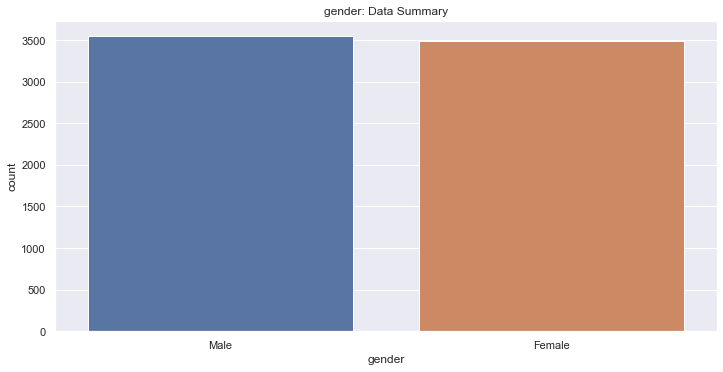

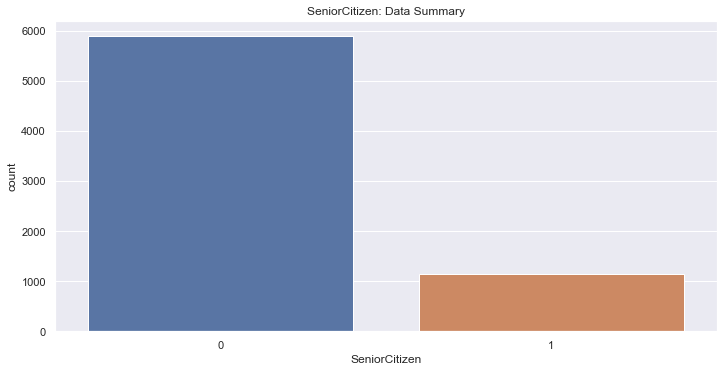

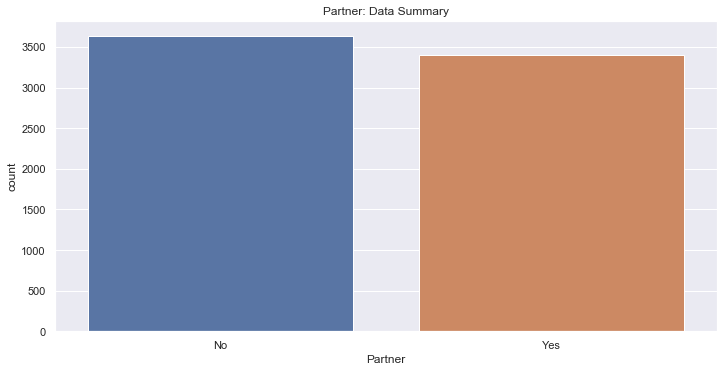

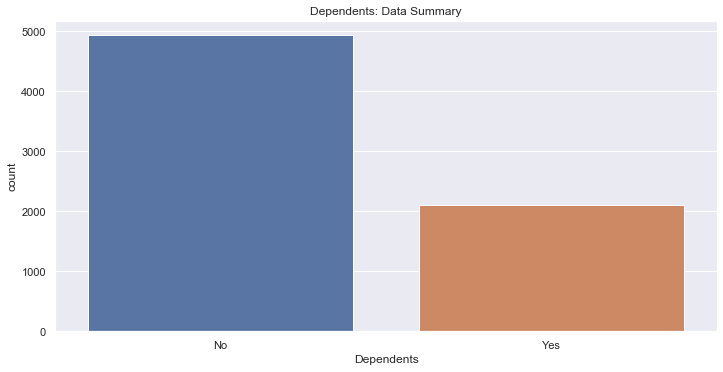

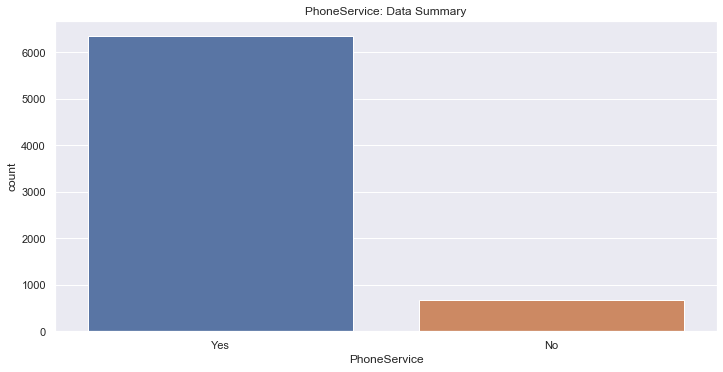

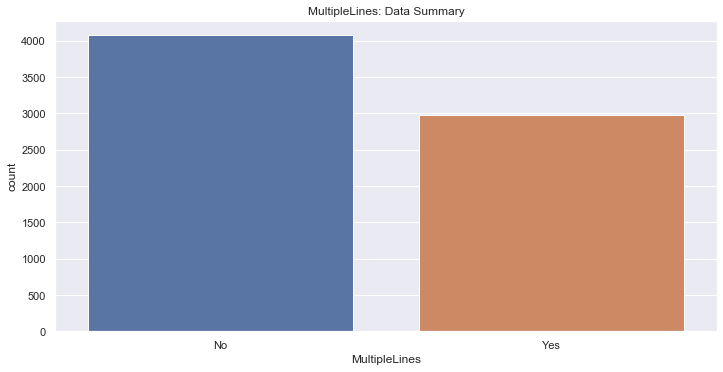

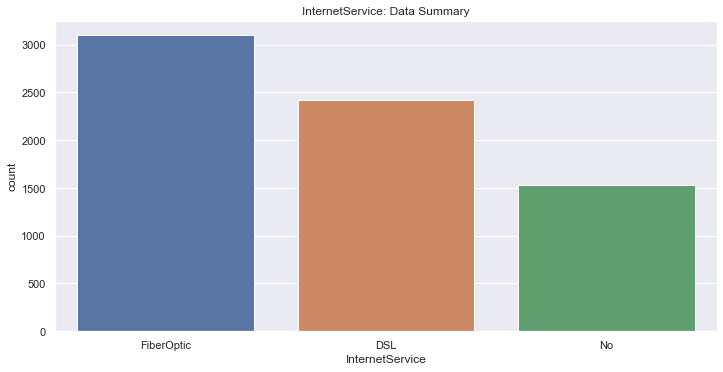

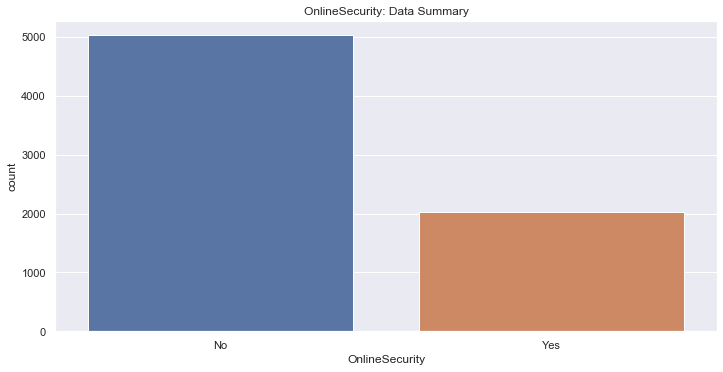

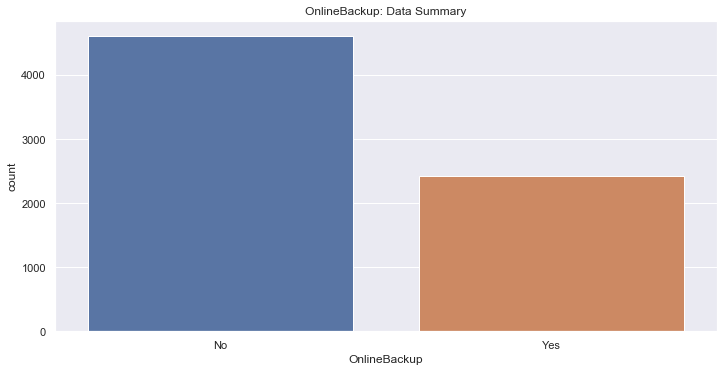

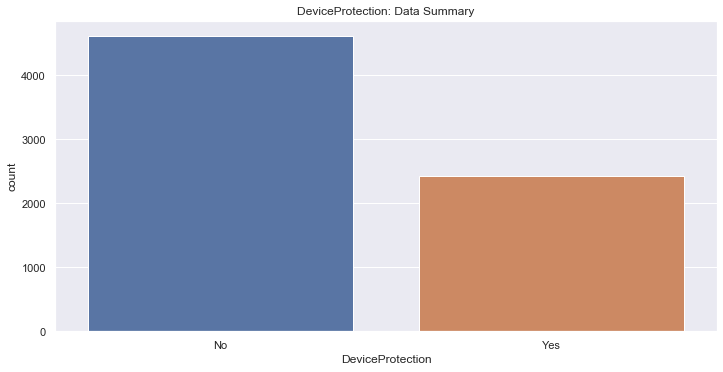

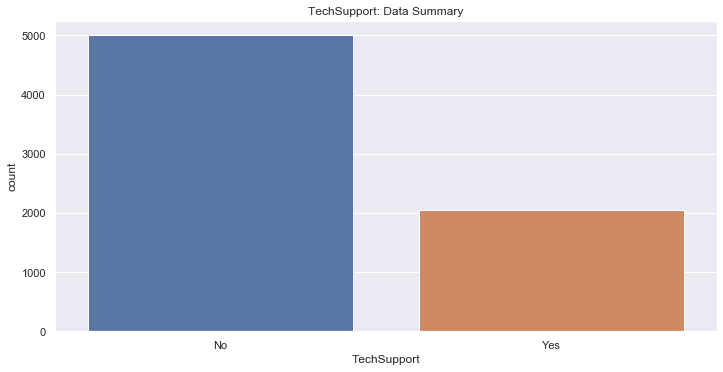

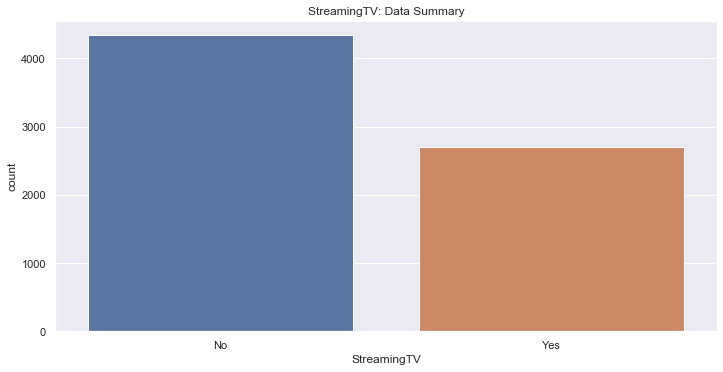

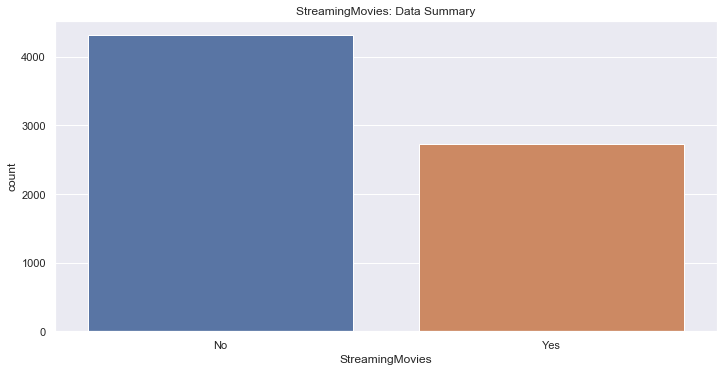

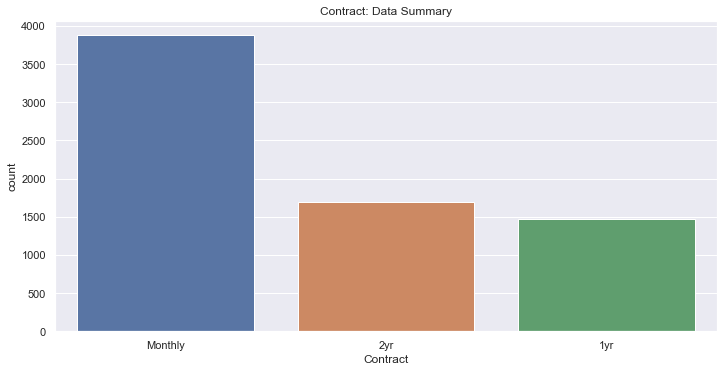

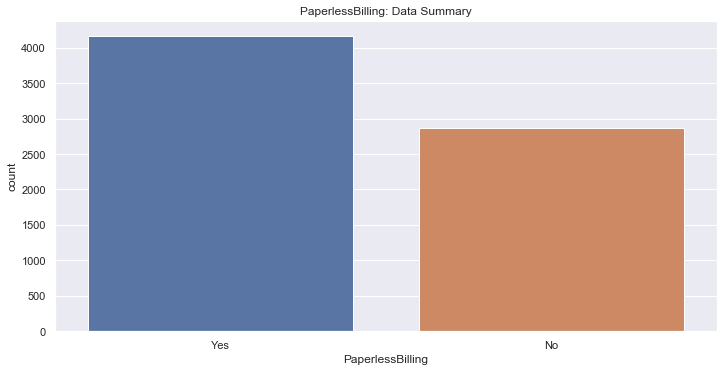

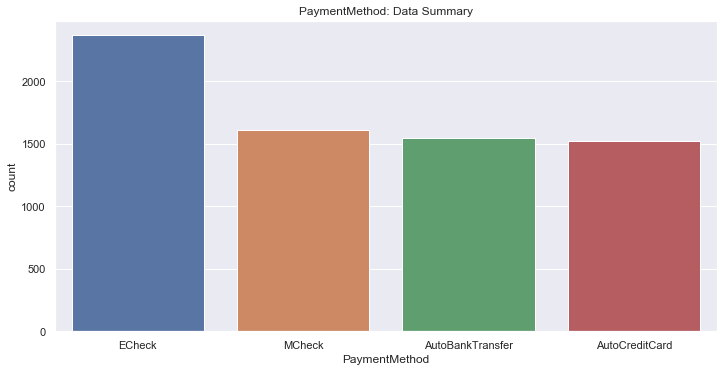

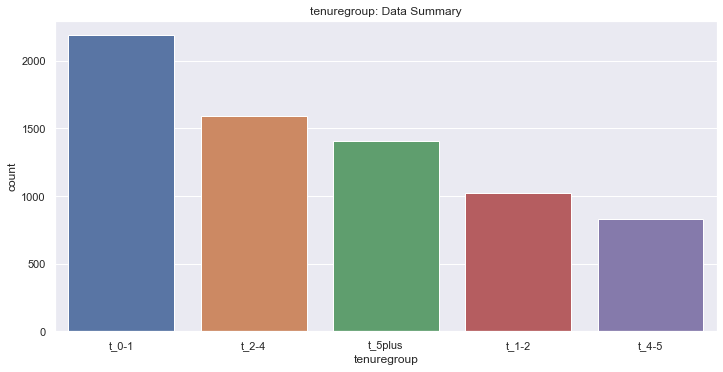

In [22]:
# Count Plot for all Categorical Features

fig,ax = plt.subplots(figsize=(5,7))
plt.close("all")
sns.set(font_scale=1)

for col in cat_columns:    
    plt.subplots(figsize=(10,5))
    #plt.figure()    
    plt.tight_layout()
    sns.countplot(x=col, data=telecom, order = telecom[col].value_counts().index).set_title(f"{col}: Data Summary")

# Will be plotted in Descending order of the value count by feature levels    
    
    

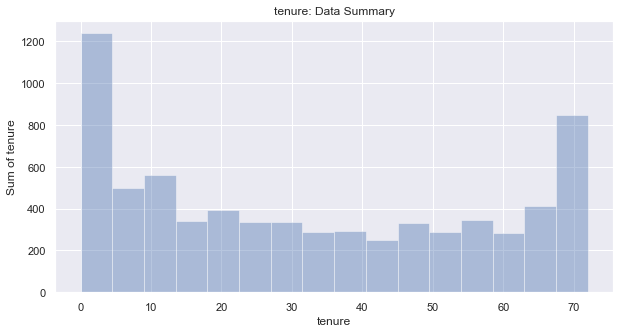

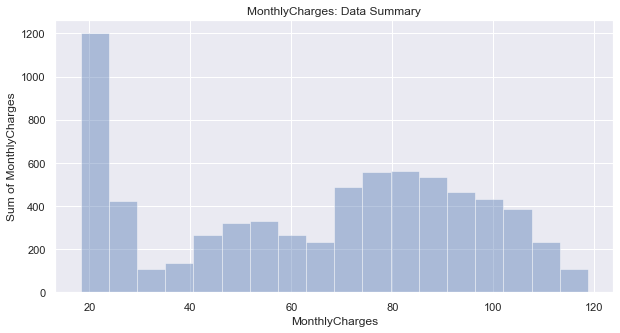

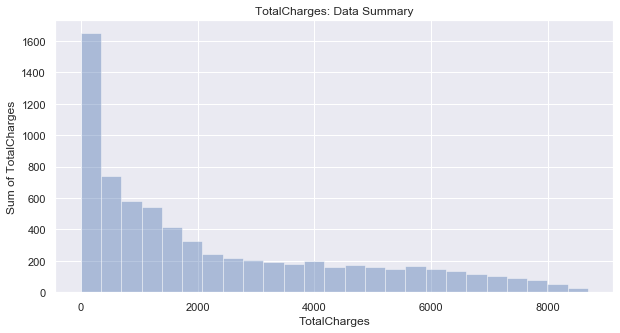

In [23]:
# Histogram and Density Plots for continuous features

#1. Histograms

for col in num_columns:
    #plt.subplots(figsize=(10,5))
    plt.figure(figsize=(10,5))    
    plt.tight_layout()
    sns.distplot(telecom[col], kde=False, hist=True).set_title(f"{col}: Data Summary")
    #plt.xlabel(col)
    plt.ylabel(f"Sum of {col}")

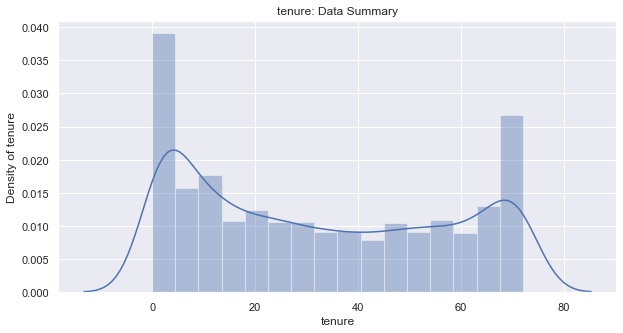

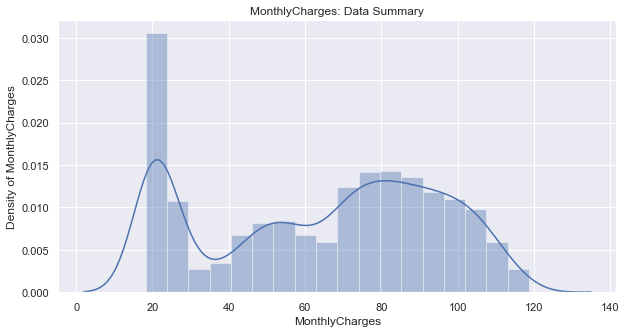

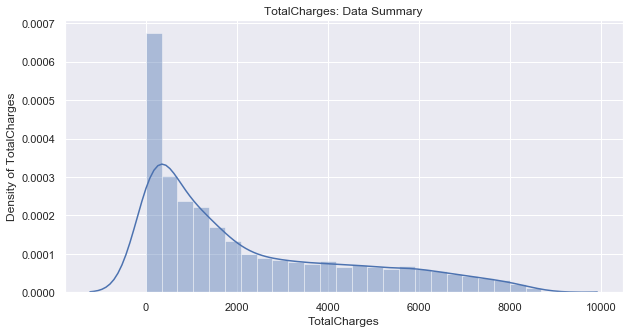

In [24]:
# 2. Density Plots

for col in num_columns:
    plt.figure(figsize=(10,5))    
    plt.tight_layout()
    sns.distplot(telecom[col], kde=True, hist=True).set_title(f"{col}: Data Summary")
    plt.ylabel(f"Density of {col}")

In [25]:
# Check Percentage of Retained vs Churned Customers from the Data Set
retain_count = len(telecom[telecom["Churn"]=="No"])
churn_count = len(telecom[telecom["Churn"]=="Yes"])

print(f"Percentage of Retained Customers is: {(retain_count/(retain_count+churn_count))*100}")
print(f"Percentage of Churned Customers is: {(churn_count/(retain_count+churn_count))*100}")

## Obs: Classes are imbalanced and the ratio of retain to churn is 73:26

Percentage of Retained Customers is: 73.4630129206304
Percentage of Churned Customers is: 26.536987079369588


In [26]:
## Check Means with respect to the Response variable
telecom.groupby("Churn").mean() #Ignore SeniorCitizen

#Obs: 
# 1. Avg. tenure for churn customer is lower than retained customers by 20 months
# 2. Avg. Monthly Charges for churned customer is higher than retained customers by 10.2
# 3. Avg. Total Charges for Churned customer is lower than retained customers by 1018.12 
#      => ties in since avg tenure for churn is lower

tenure  MonthlyCharges  TotalCharges
Churn                                         
No     37.569965       61.265124   2549.911443
Yes    17.979133       74.441332   1531.796092

In [ ]:
#dx.count("Churn", split="InternetService", data=telecom, stacked=True, split_order=telecom.InternetService.unique().tolist())

In [ ]:
# Calculate Categorical for other categorical variables 

In [27]:
telecom.groupby("SeniorCitizen").mean()
# Obs: The averages between SeniorCitizen and Young Customers are almost similar, with an exception of TotalCharges
#       which could mean that SeniorCitizen opt of more # of services than younger customers. 

tenure  MonthlyCharges  TotalCharges
SeniorCitizen                                         
0              32.192171       61.847441   2177.023801
1              33.295972       79.820359   2810.465195

In [28]:
telecom.groupby("Partner").mean() #Ignore SeniorCitizen
# Obs: The averages are higher for Partners than non-Partners.  

tenure  MonthlyCharges  TotalCharges
Partner                                         
No       23.357869       61.945001   1584.089812
Yes      42.017637       67.776264   3024.249764

In [29]:
# Similar observations can be made for rest of the categorical means
for col in cat_columns:
    print(f"\033[1m {col} Avg: \033[0;0m\n {telecom.groupby(col).mean()} \n")

 gender Avg: 
            tenure  MonthlyCharges  TotalCharges
gender                                         
Female  32.244553       65.204243   2279.918064
Male    32.495359       64.327482   2279.554007 

 SeniorCitizen Avg: 
                   tenure  MonthlyCharges  TotalCharges
SeniorCitizen                                         
0              32.192171       61.847441   2177.023801
1              33.295972       79.820359   2810.465195 

 Partner Avg: 
             tenure  MonthlyCharges  TotalCharges
Partner                                         
No       23.357869       61.945001   1584.089812
Yes      42.017637       67.776264   3024.249764 

 Dependents Avg: 
                tenure  MonthlyCharges  TotalCharges
Dependents                                         
No          29.806000       67.002808   2187.709255
Yes         38.368246       59.522156   2494.881019 

 PhoneService Avg: 
                  tenure  MonthlyCharges  TotalCharges
PhoneService                 

## Visualizations - Feature by each Response Variable class

In [30]:
## Distribution of Frequency by each class of Response variable, for all Categorical Features

churn_customers = telecom[telecom["Churn"] == "Yes"]
nochurn_customers = telecom[telecom["Churn"] == "No"]

In [31]:
# Use Matplotlib to plot the pie and histogram (with overlay) graphs
# Display frequency of each of the categorical feature by Churn level

sns.set(font_scale=2)
colors = ["lightskyblue", "lightcoral", "royalblue", "red", "green","yellowgreen", "gold", ]
def category_plots(colname):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,12))
    churn_dist = ax1.pie(churn_customers[colname].value_counts().values.tolist(), \
                         autopct = "%1.1f%%", \
                         startangle = 90, \
                         labels = churn_customers[colname].unique().tolist(), \
                         textprops={'size': 'small'}, colors = colors)

    nochurn_dist = ax2.pie(nochurn_customers[colname].value_counts().values.tolist(), \
                           autopct = "%1.1f%%", startangle = 90, \
                           labels = nochurn_customers[colname].unique().tolist(), \
                           textprops={'size': 'small'}, colors = colors)

    fig.suptitle(f"{colname} Churn vs Retention Distribution", verticalalignment = "baseline")
    fig = plt.gcf()

    ax1.set_title("Churned Customers", fontdict = {'verticalalignment': "top"}, loc = "center", pad = -10)
    ax2.set_title("Retained Customers", fontdict = {'verticalalignment': "top"}, loc = "center", pad = -10)

    plt.tight_layout()
    plt.show()

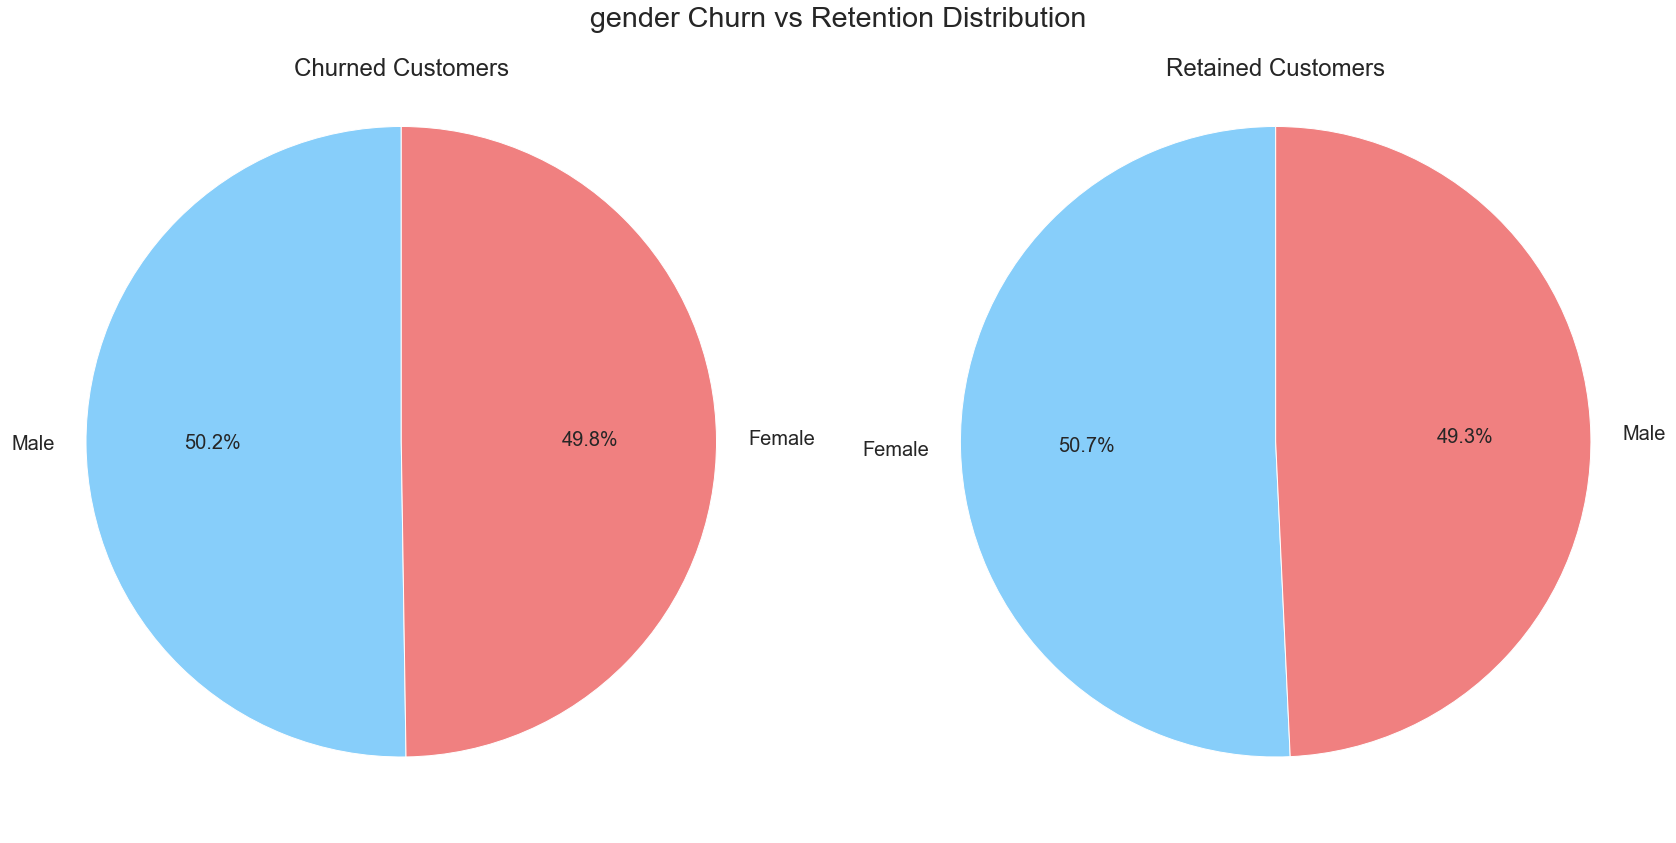

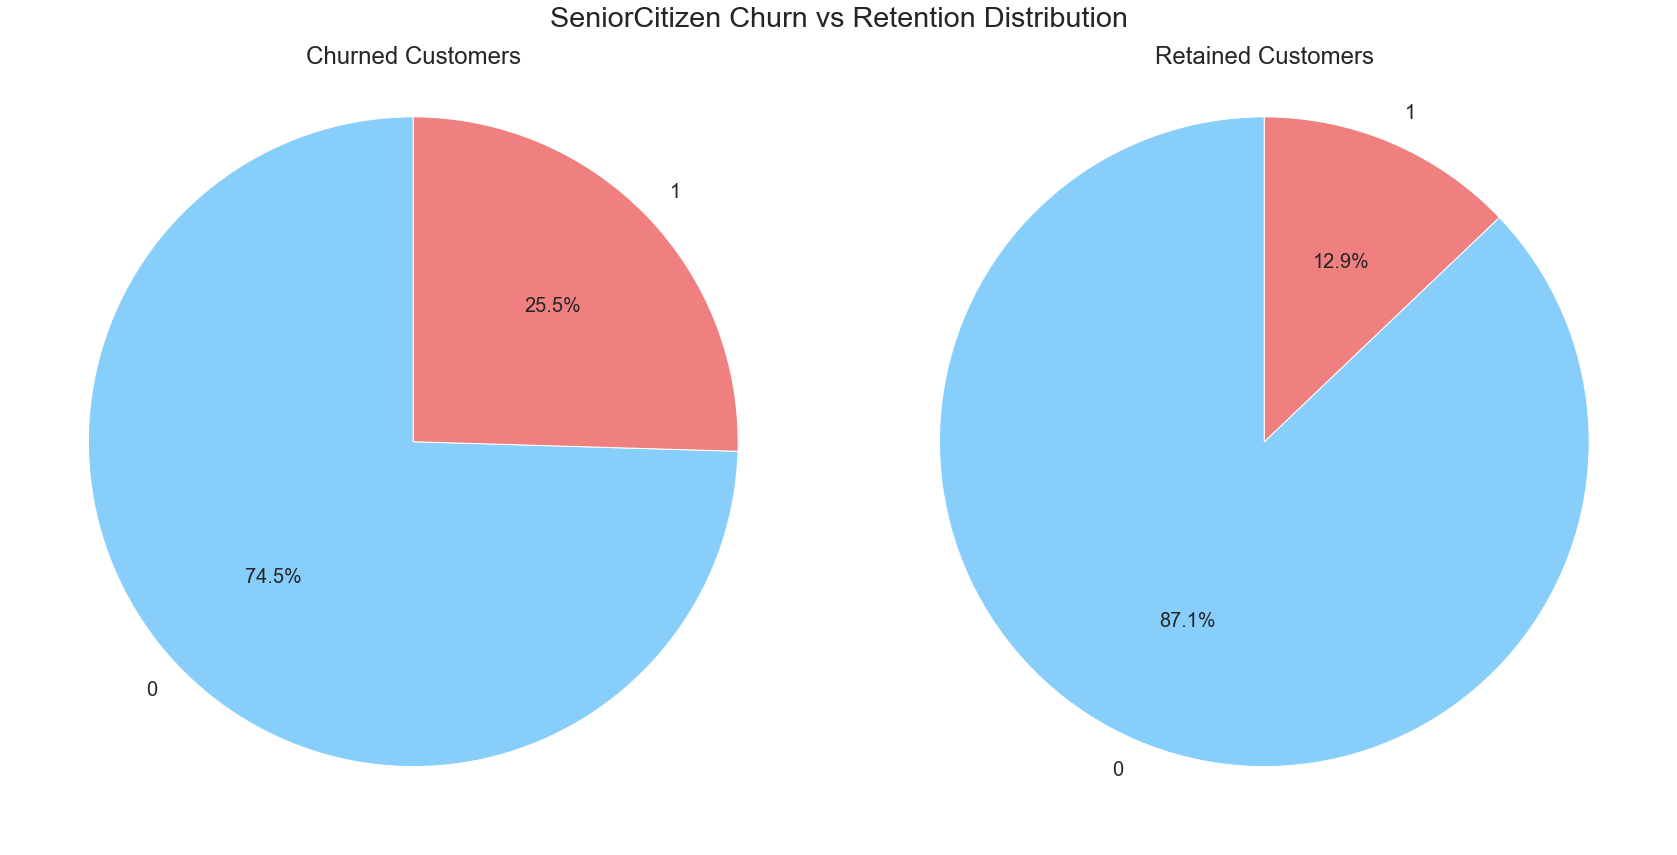

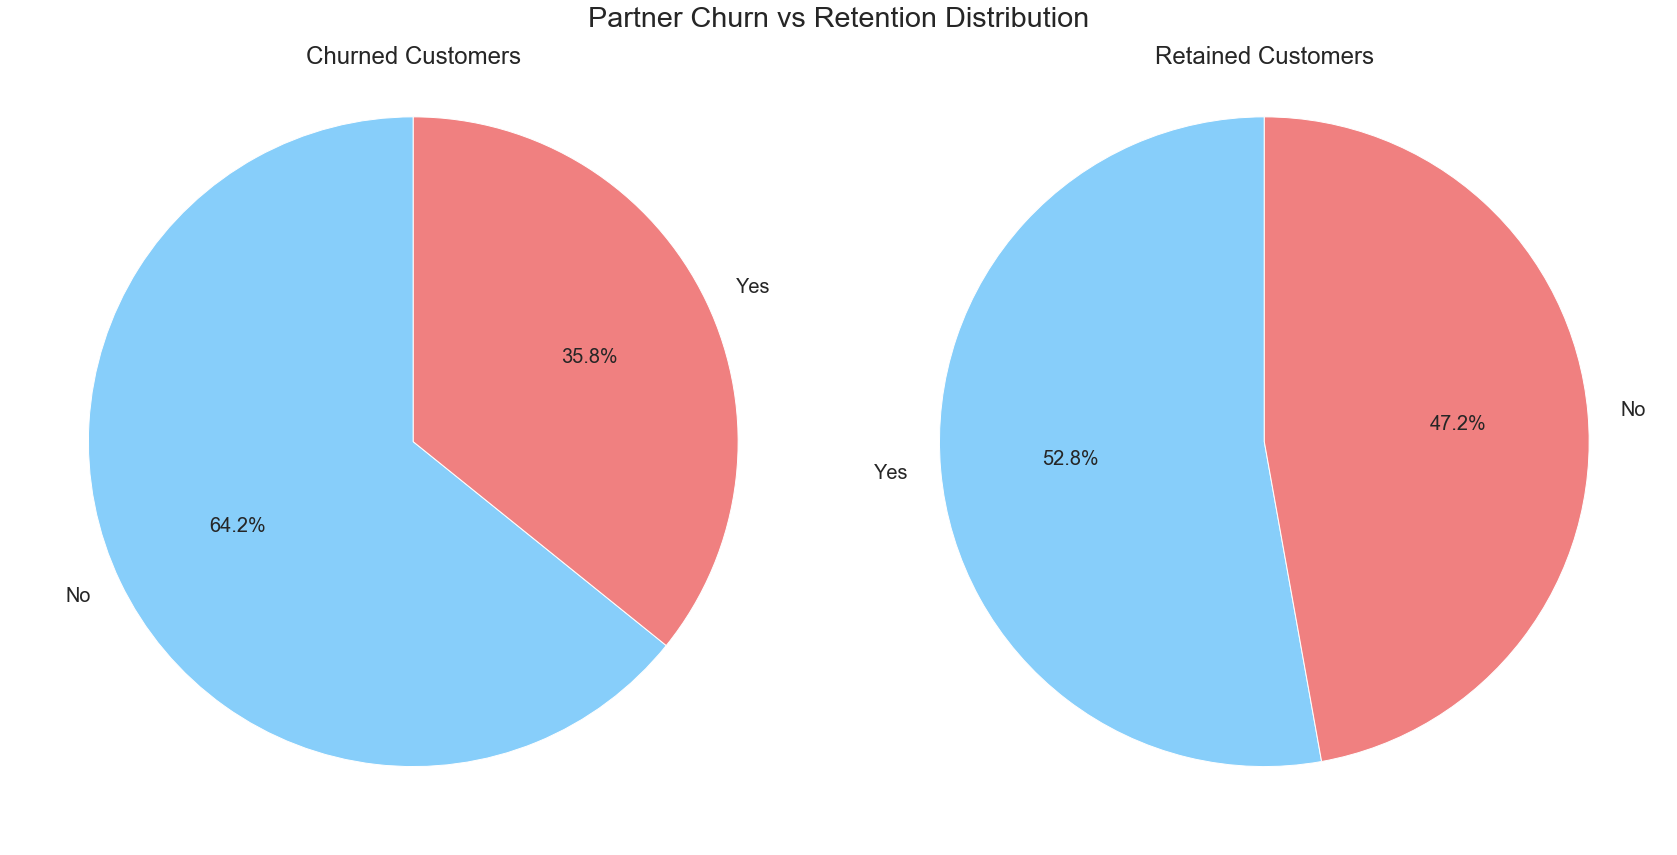

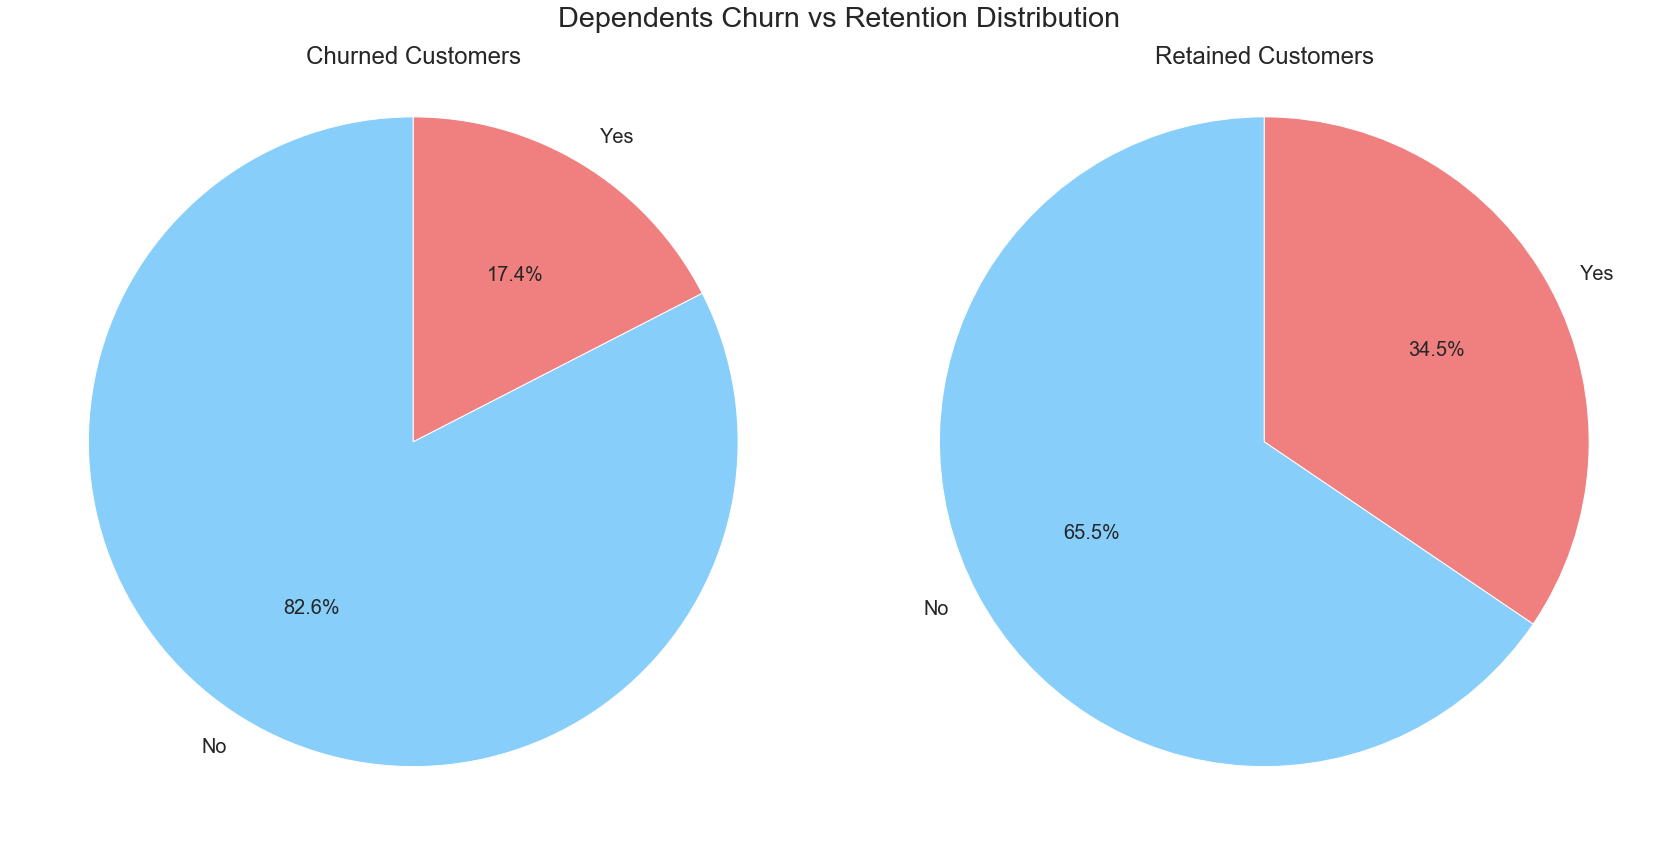

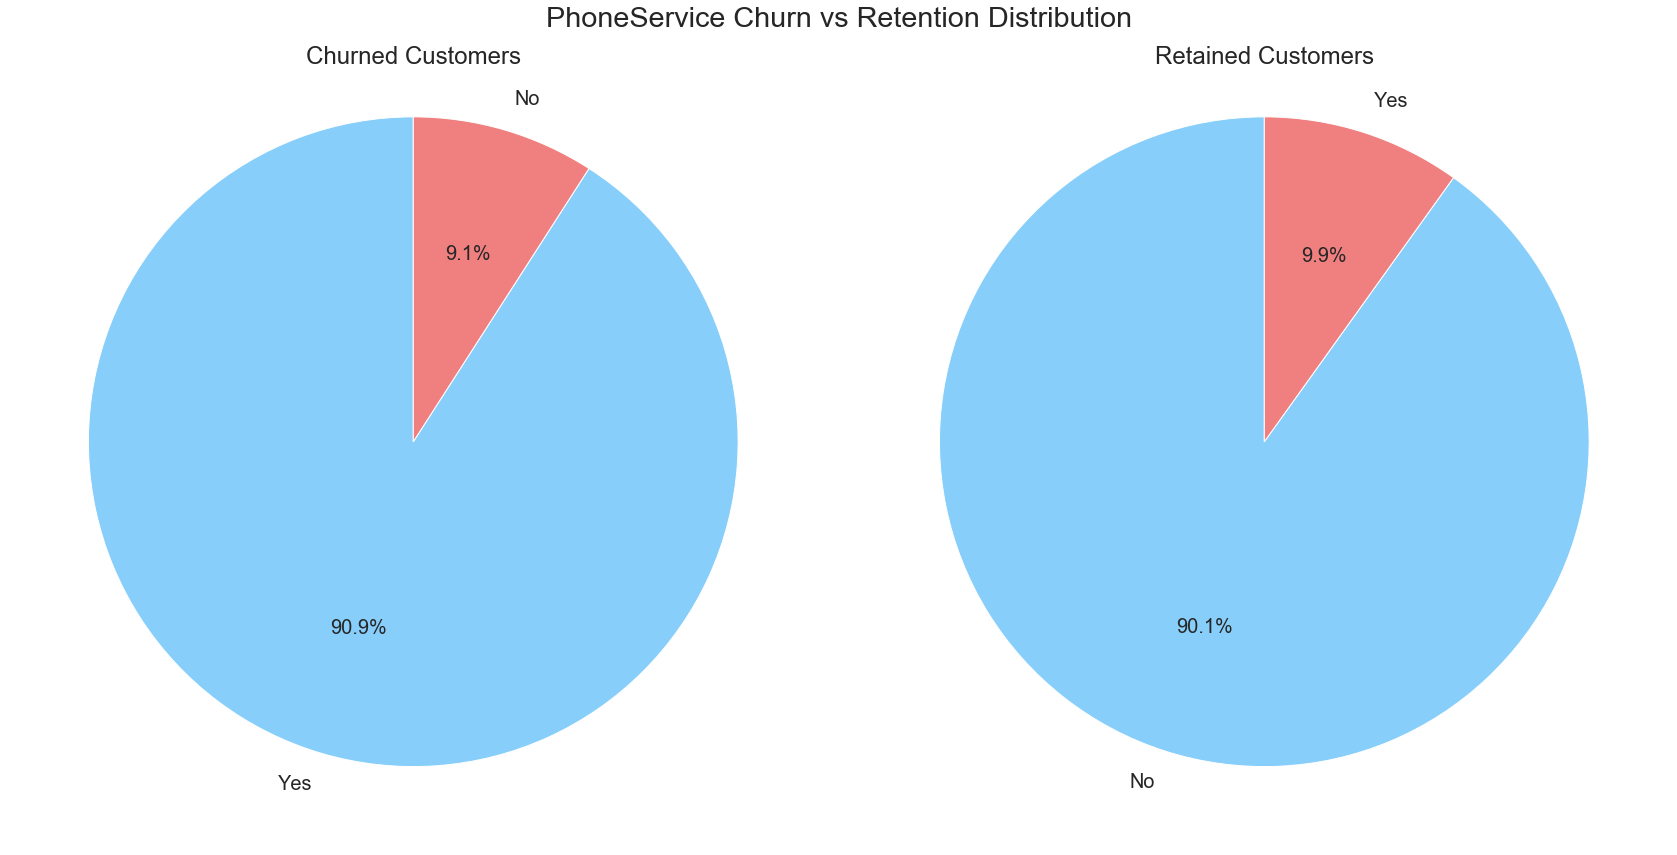

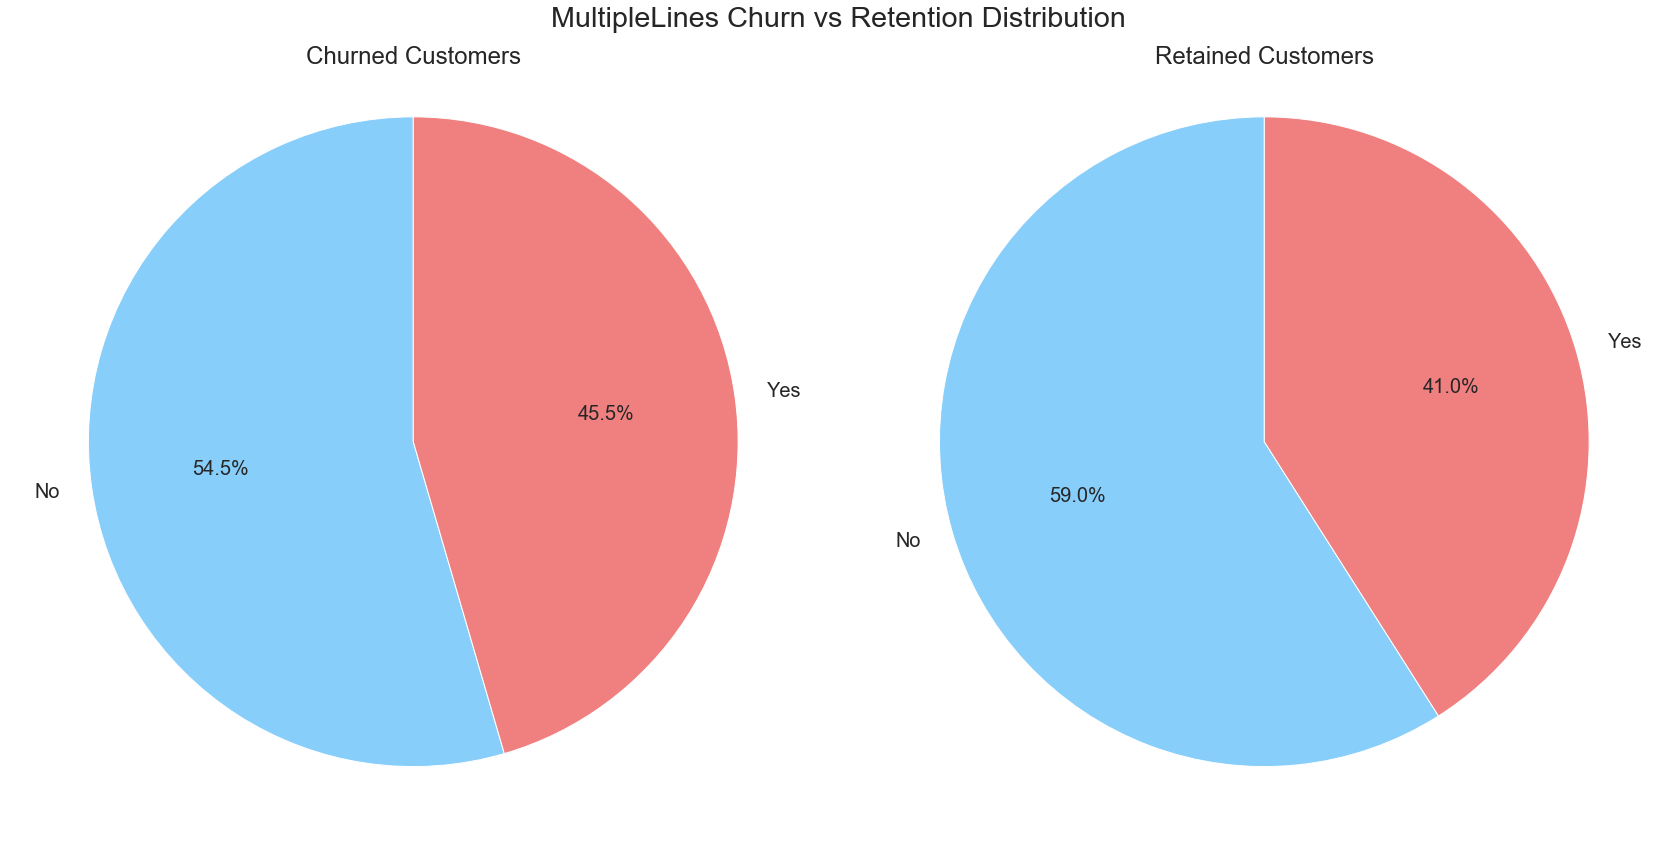

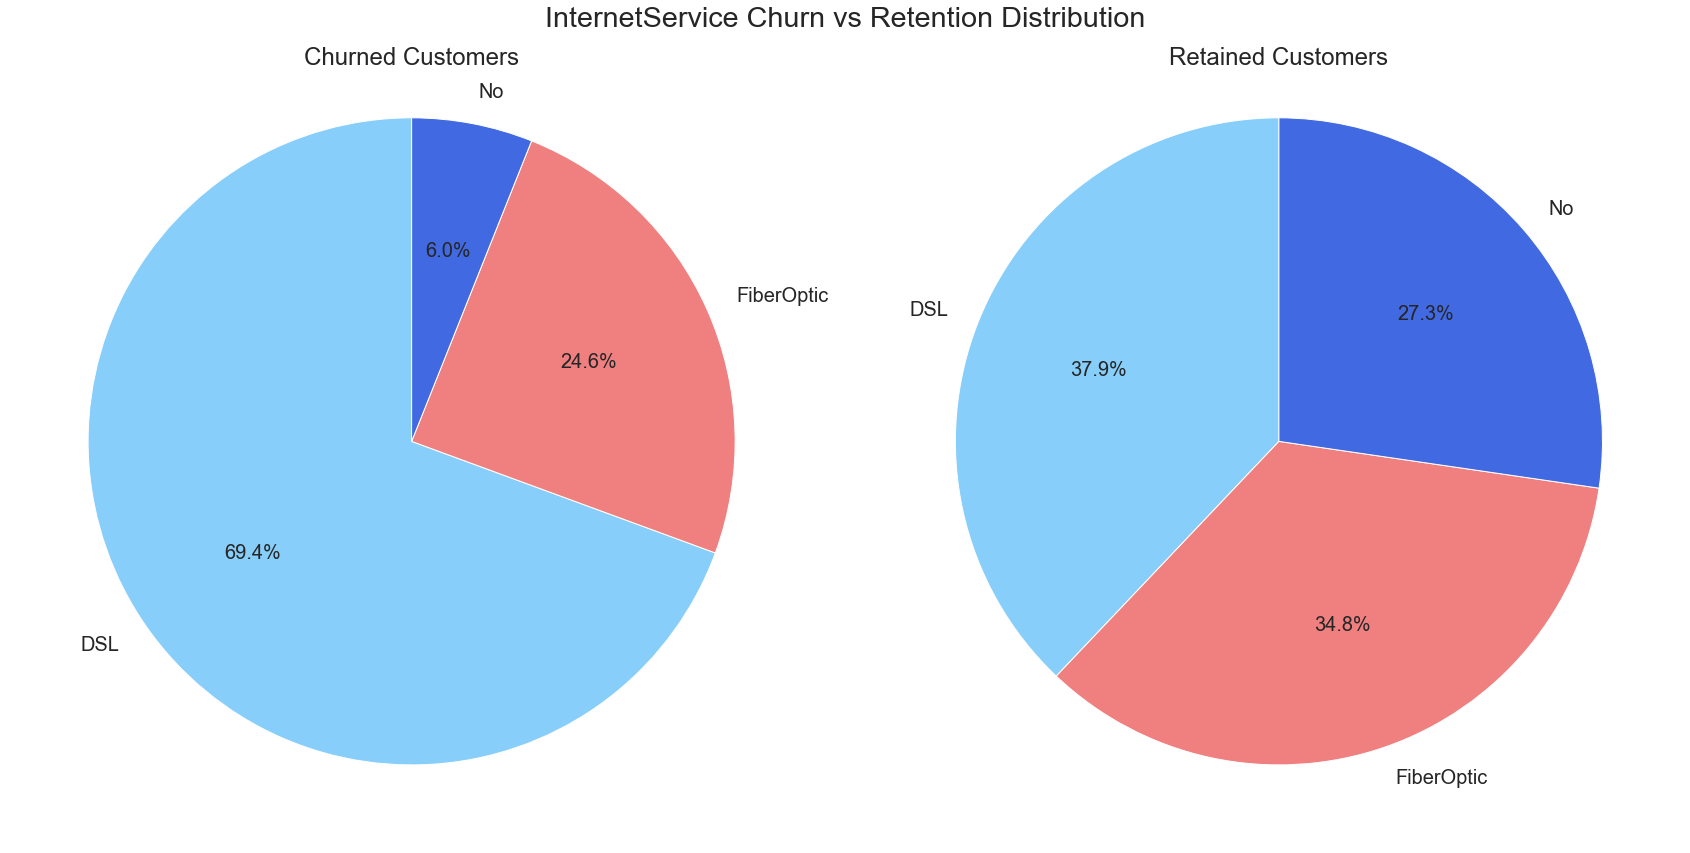

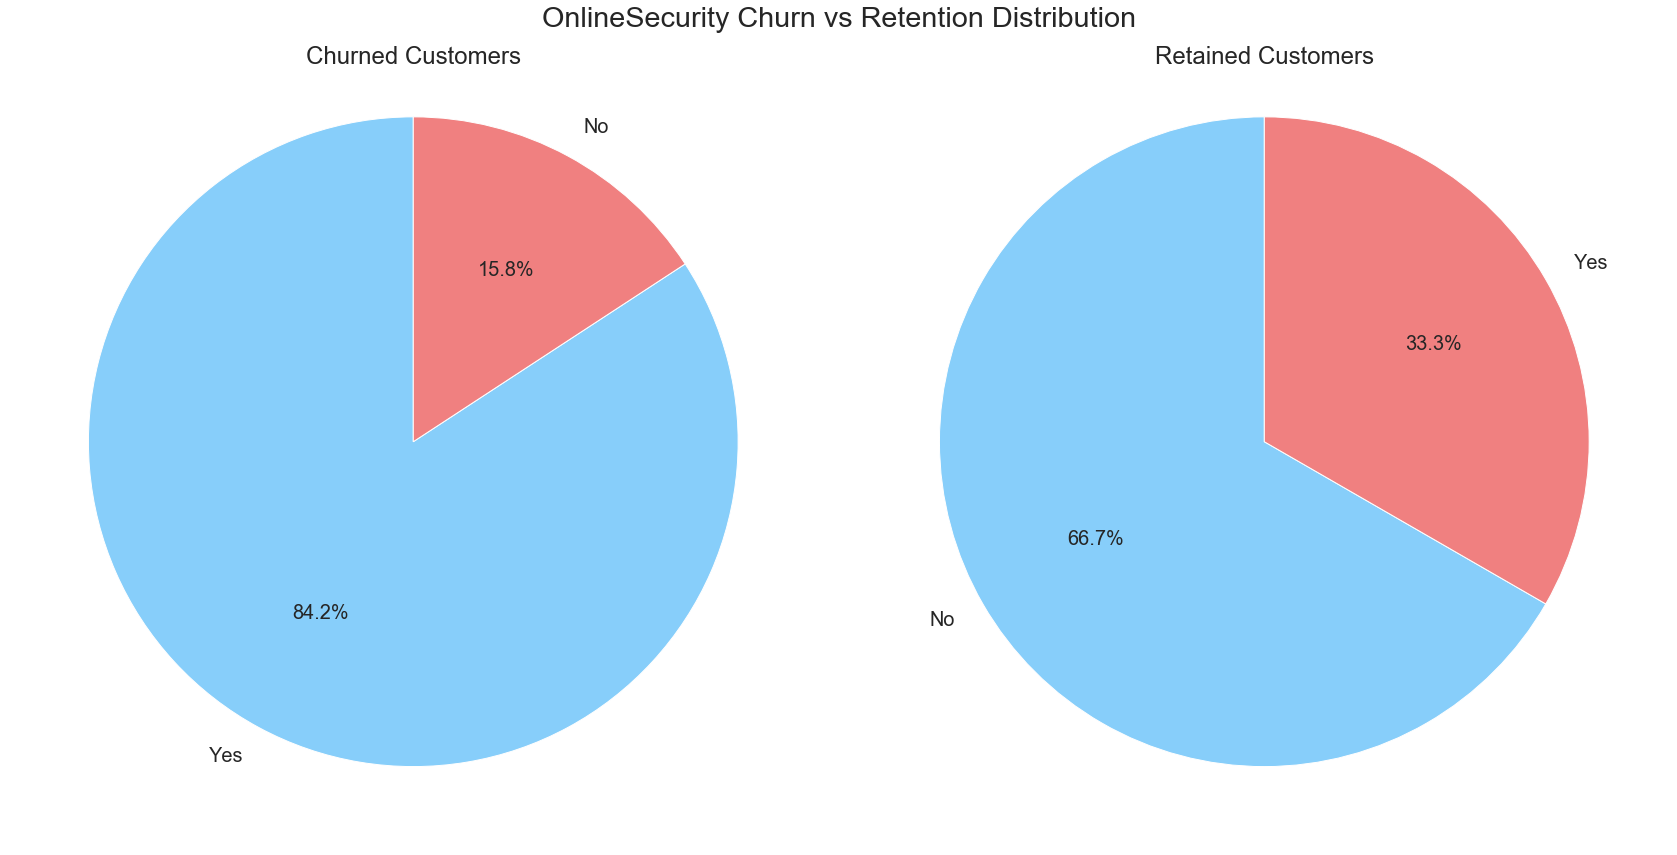

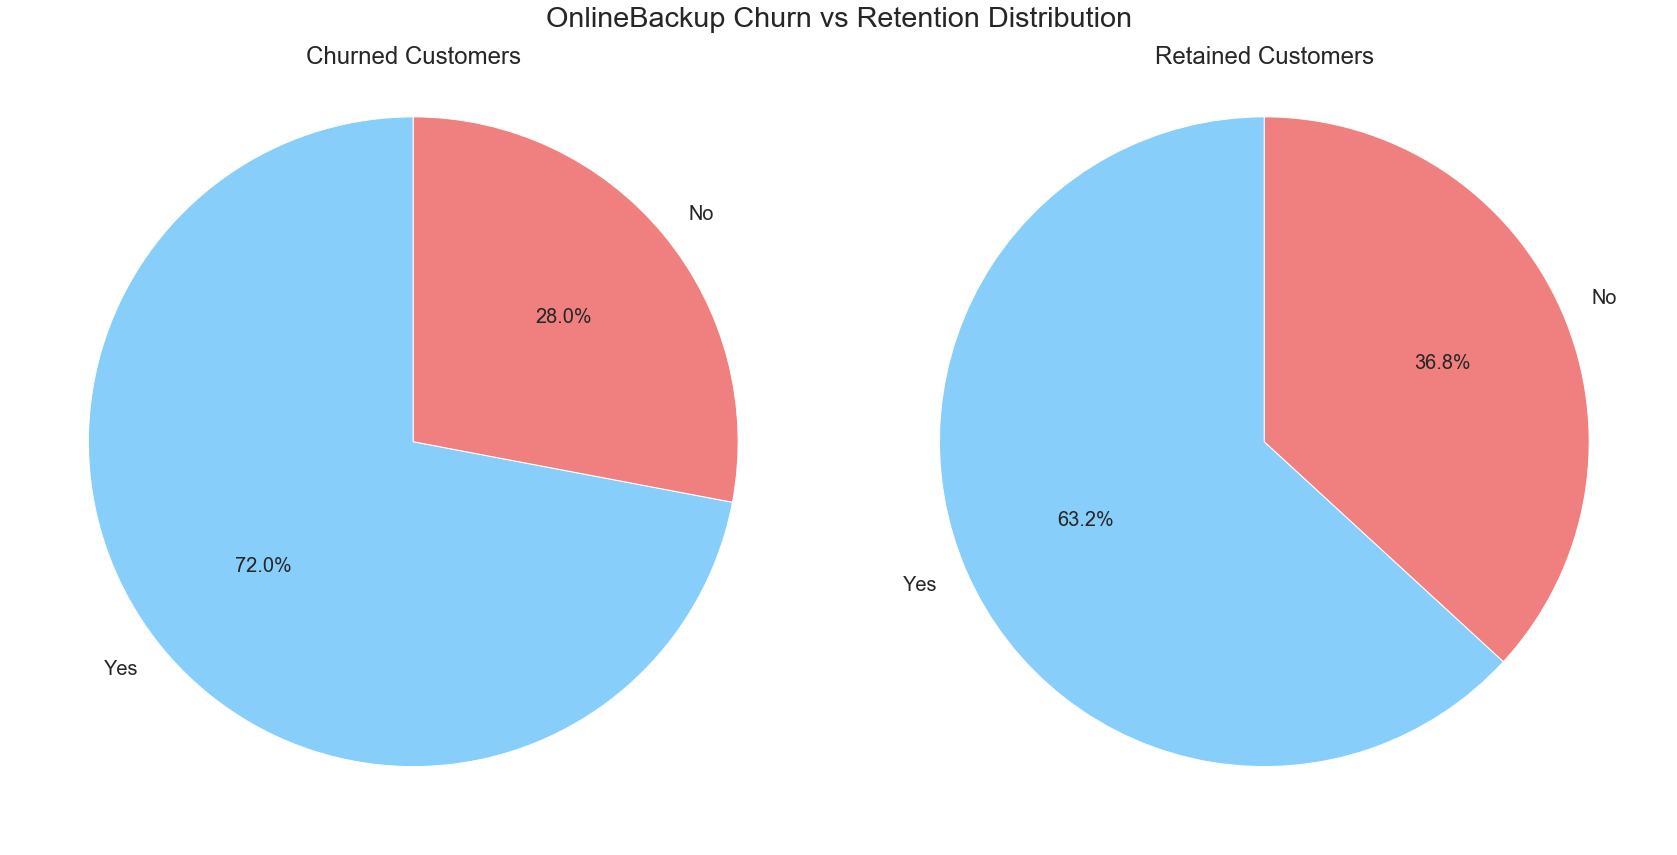

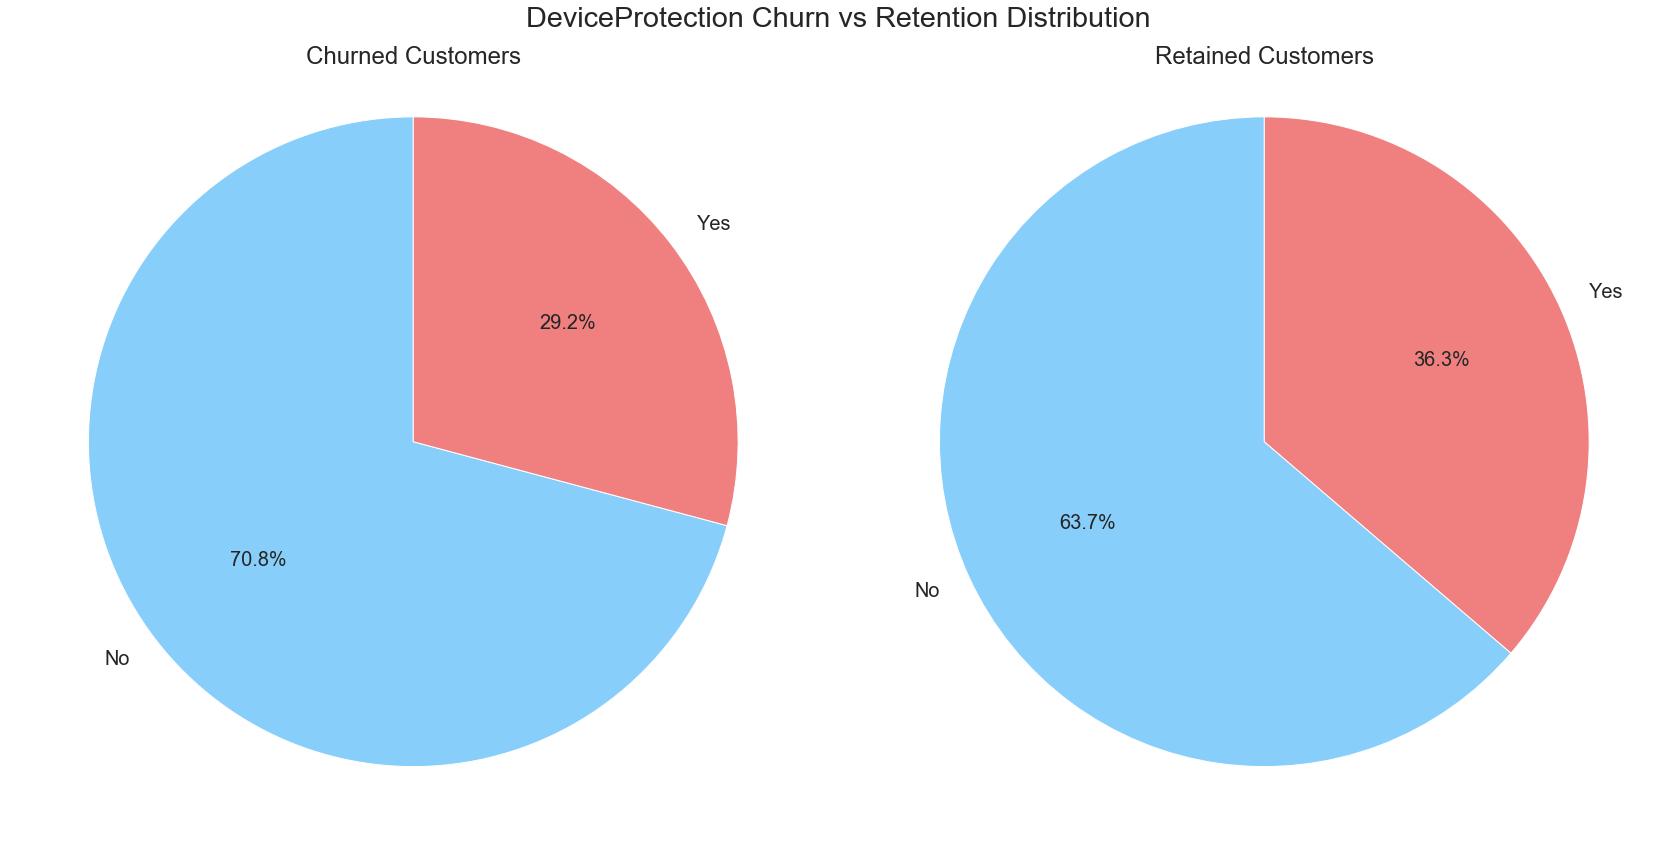

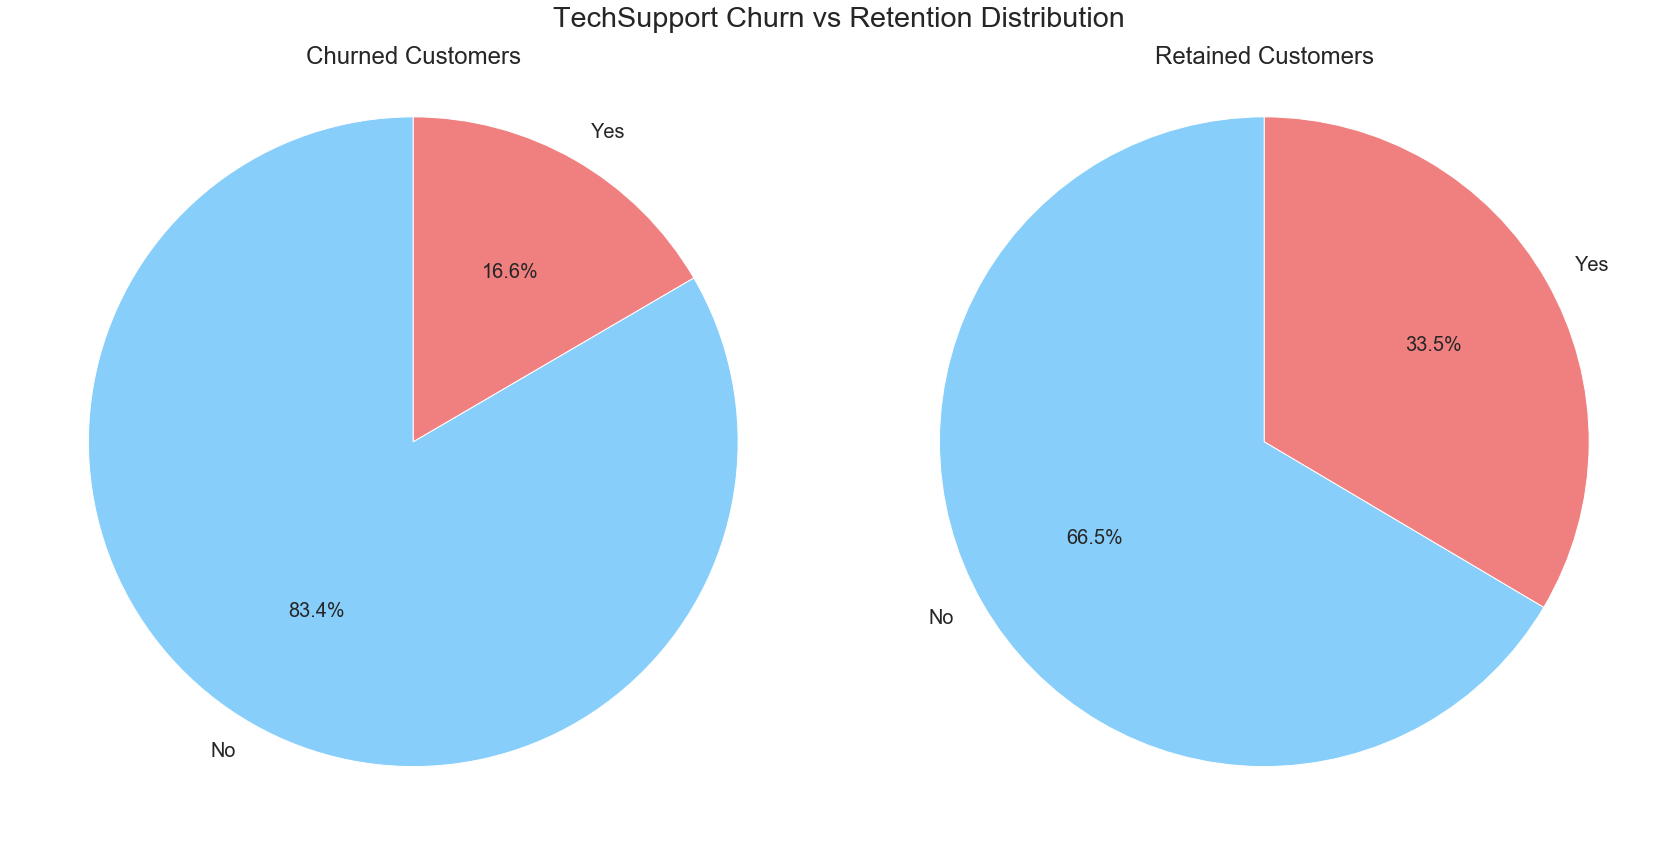

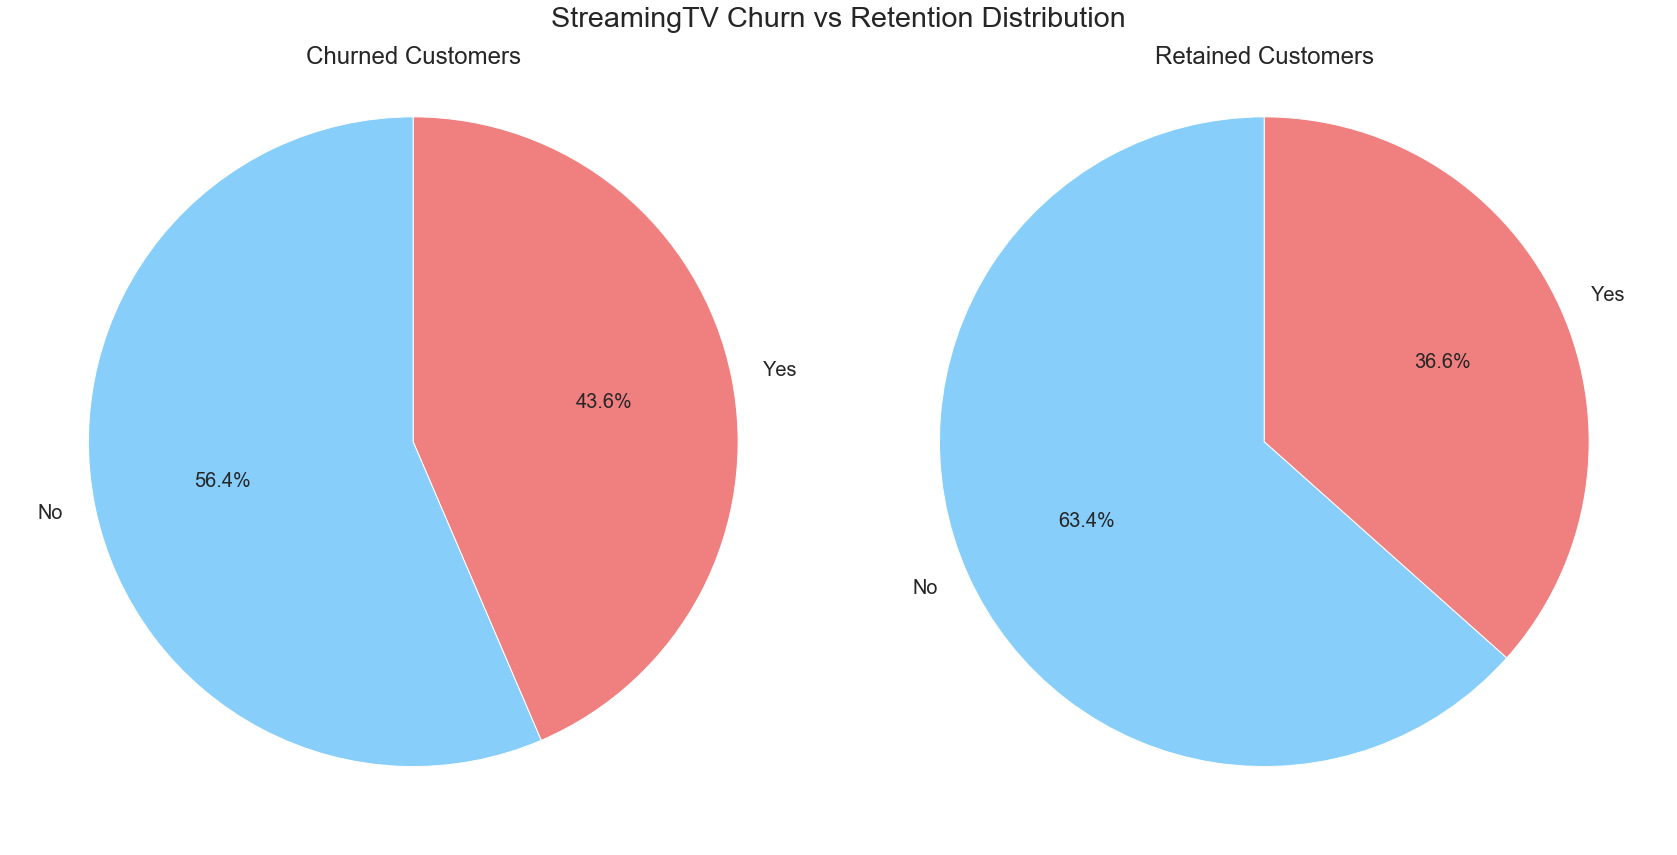

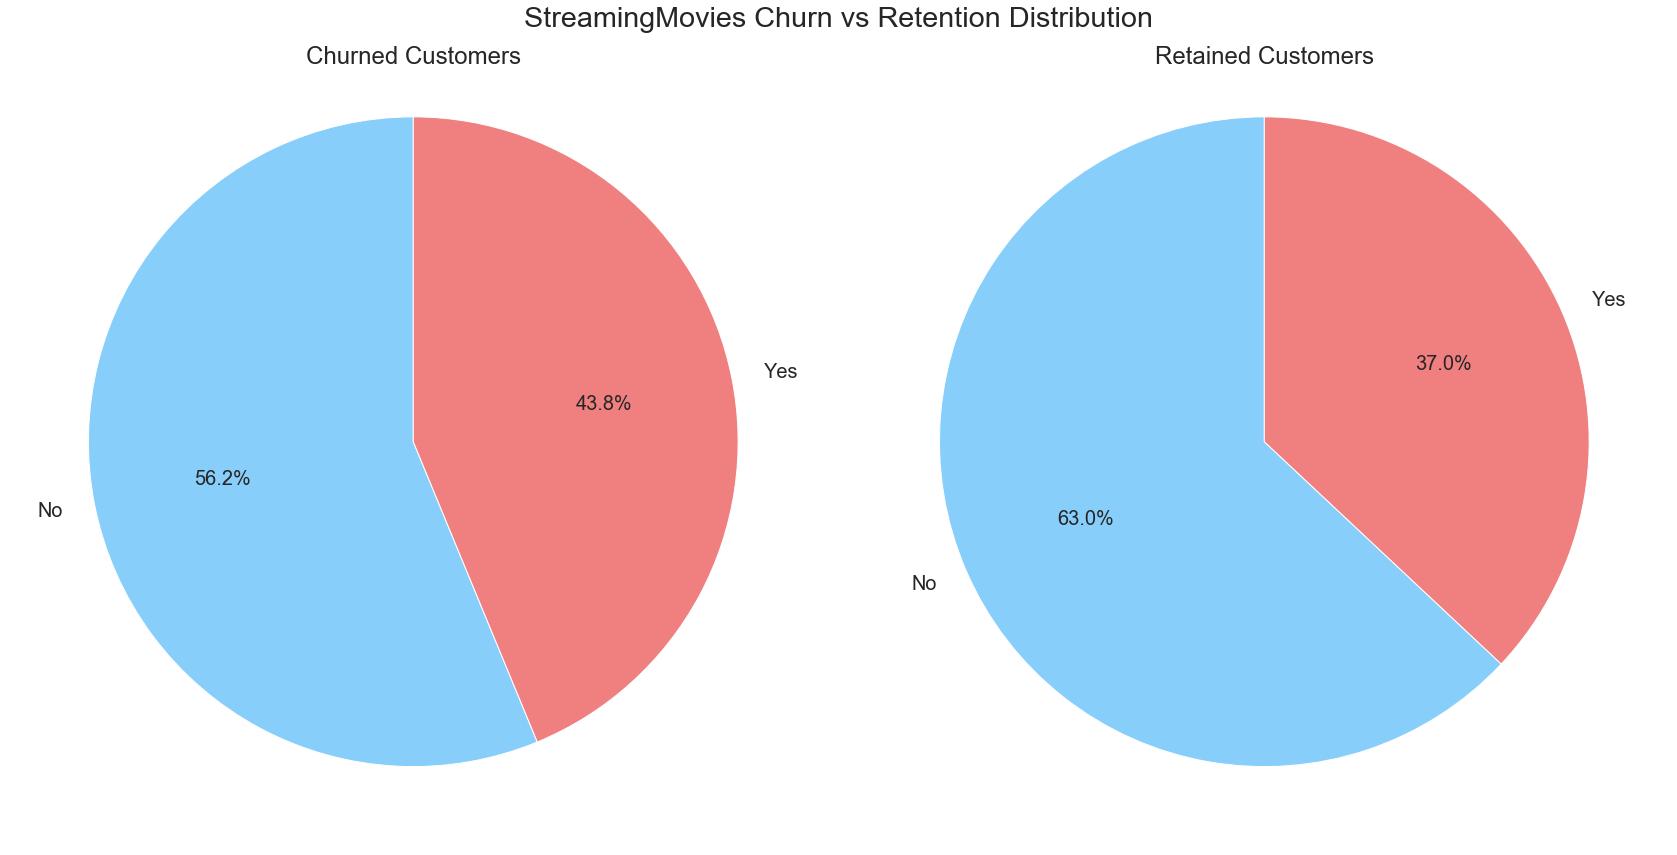

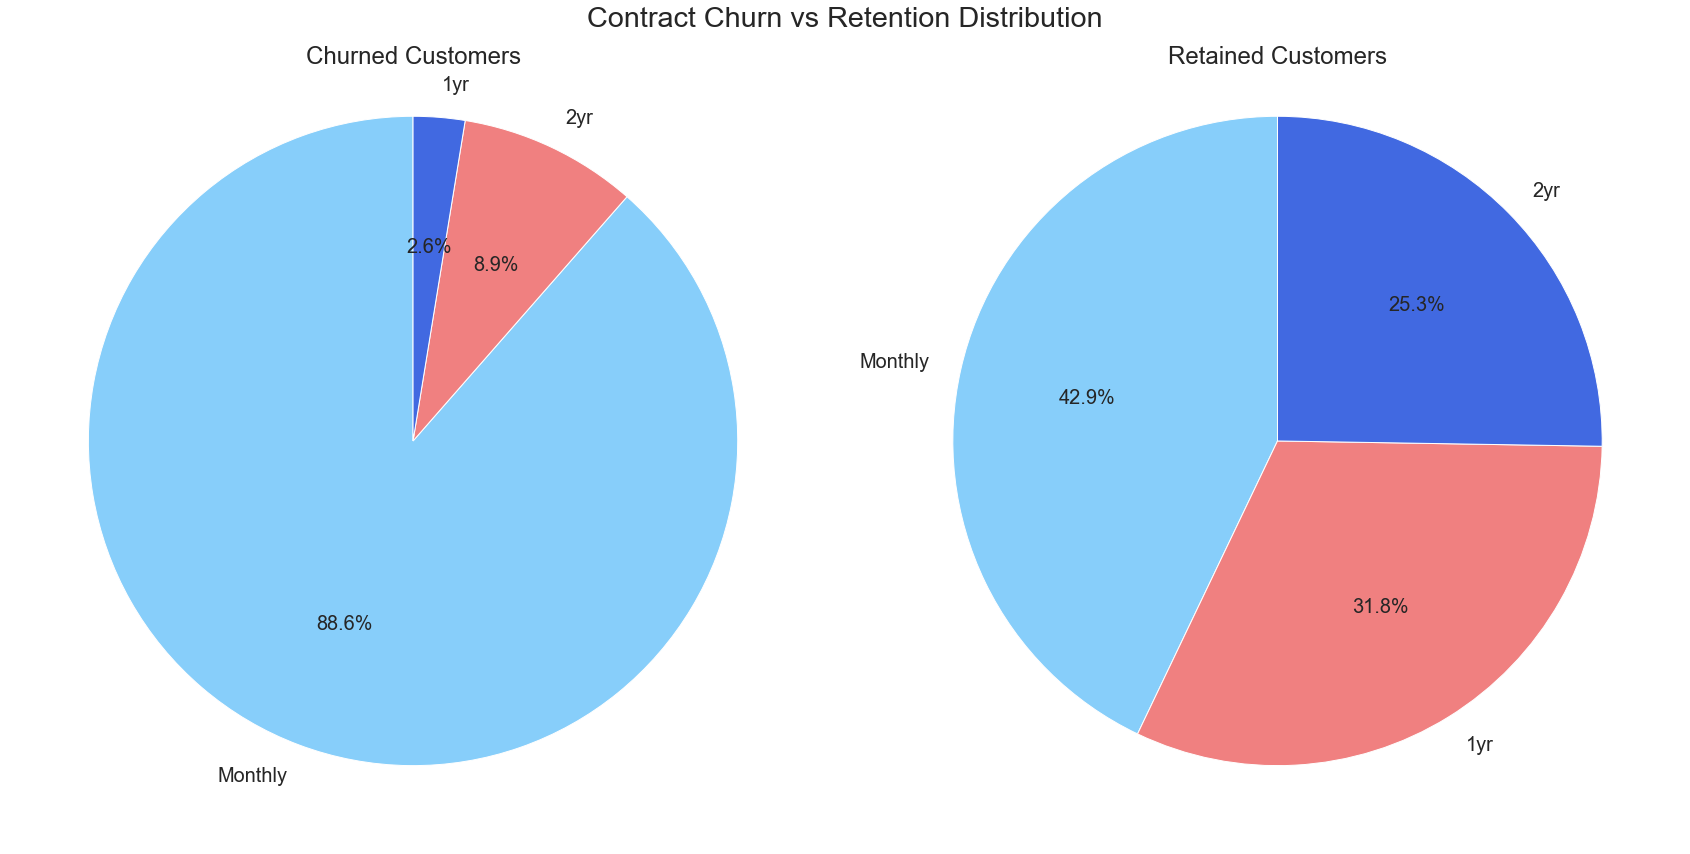

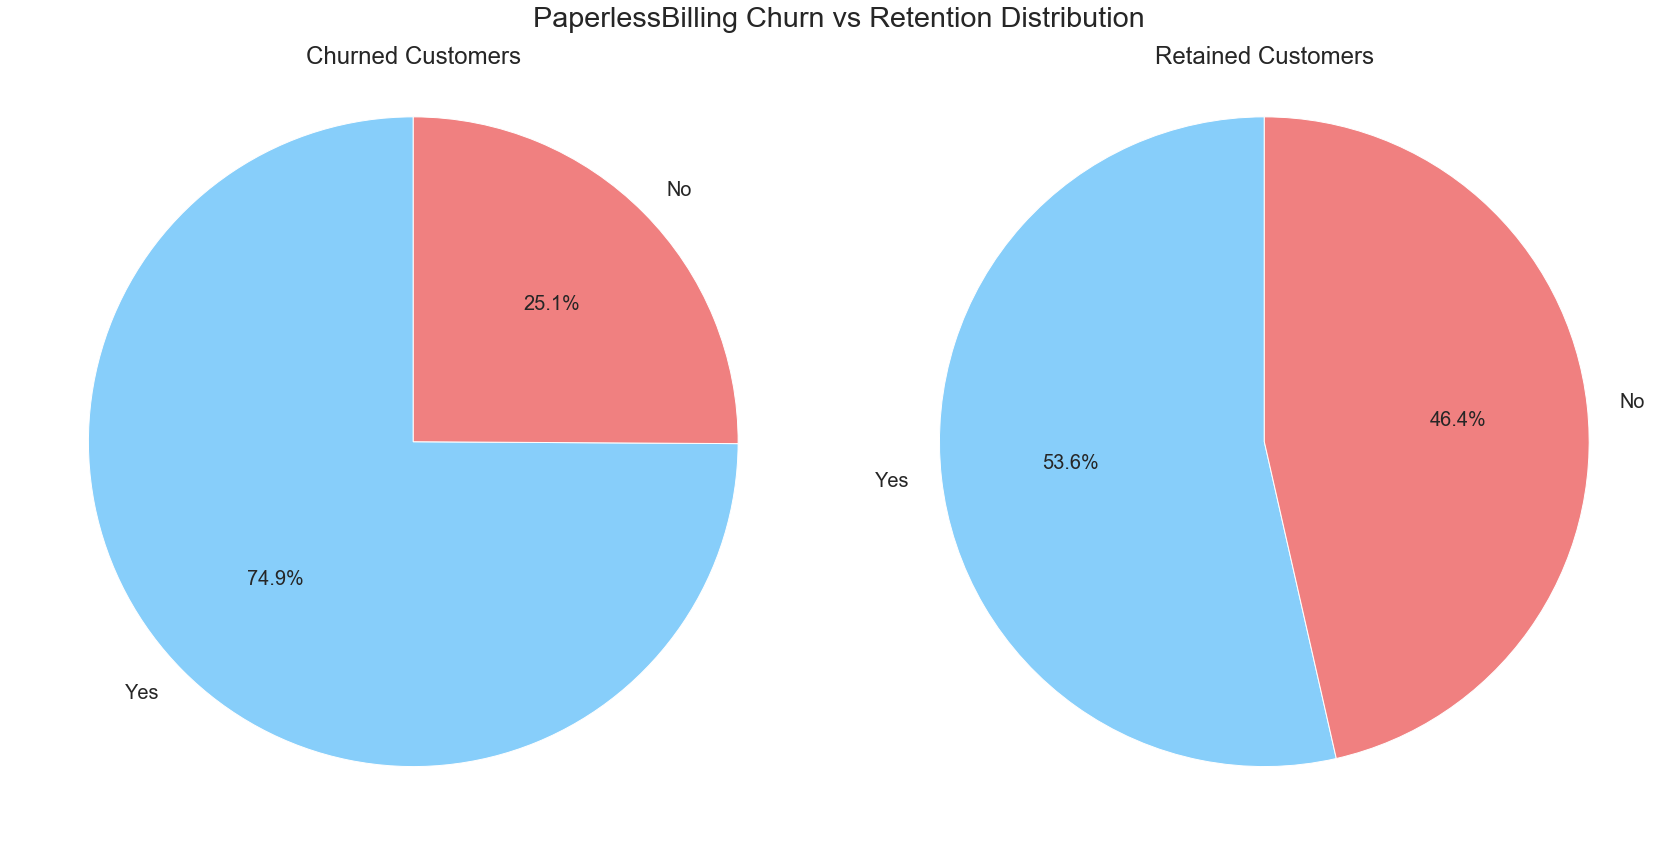

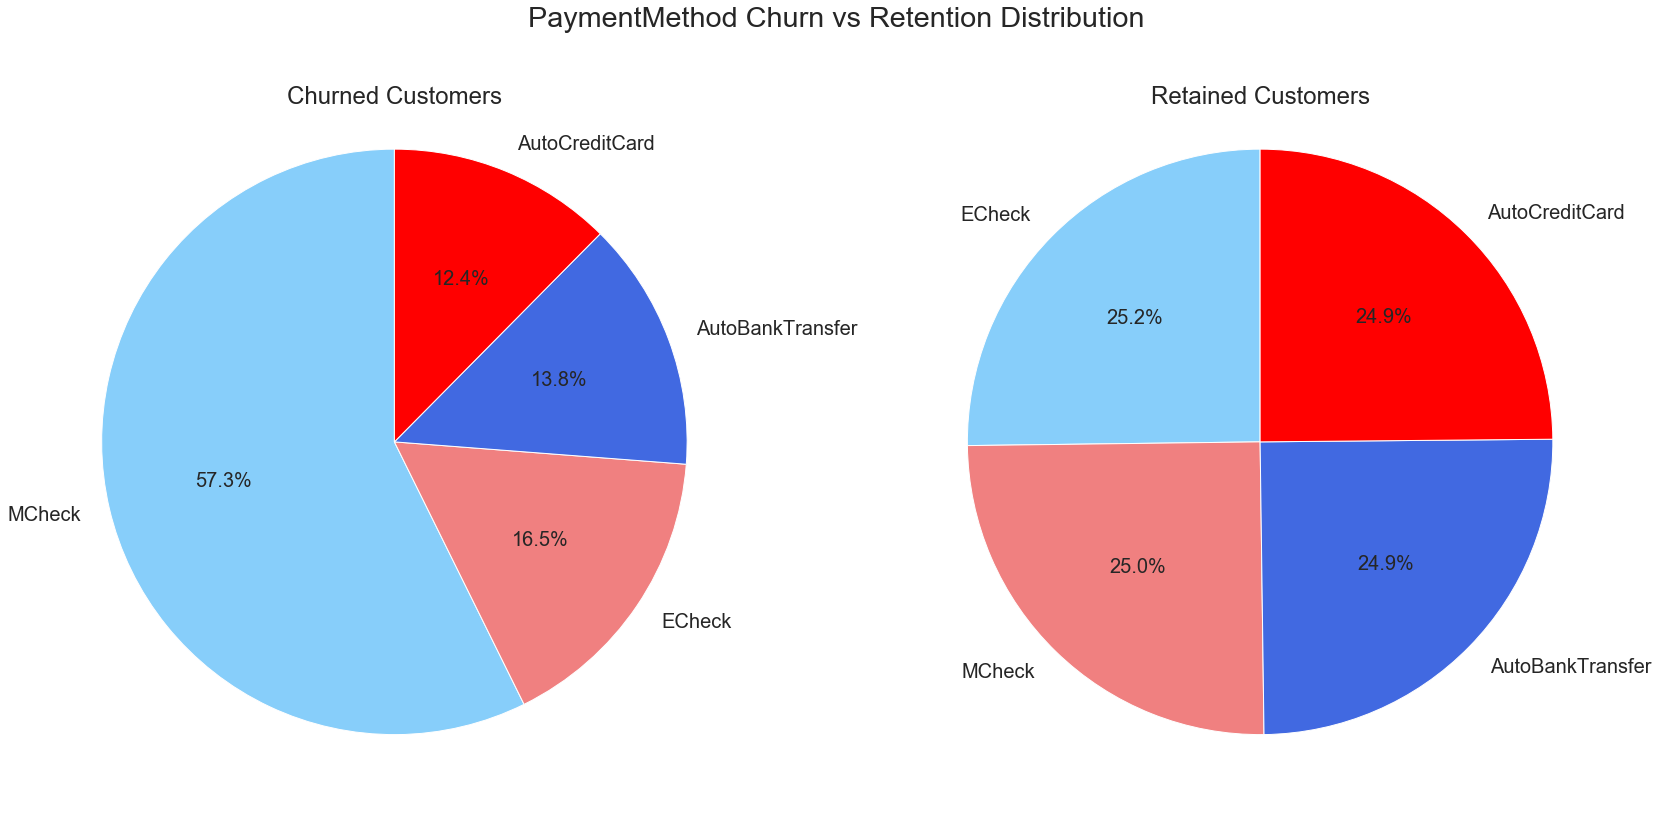

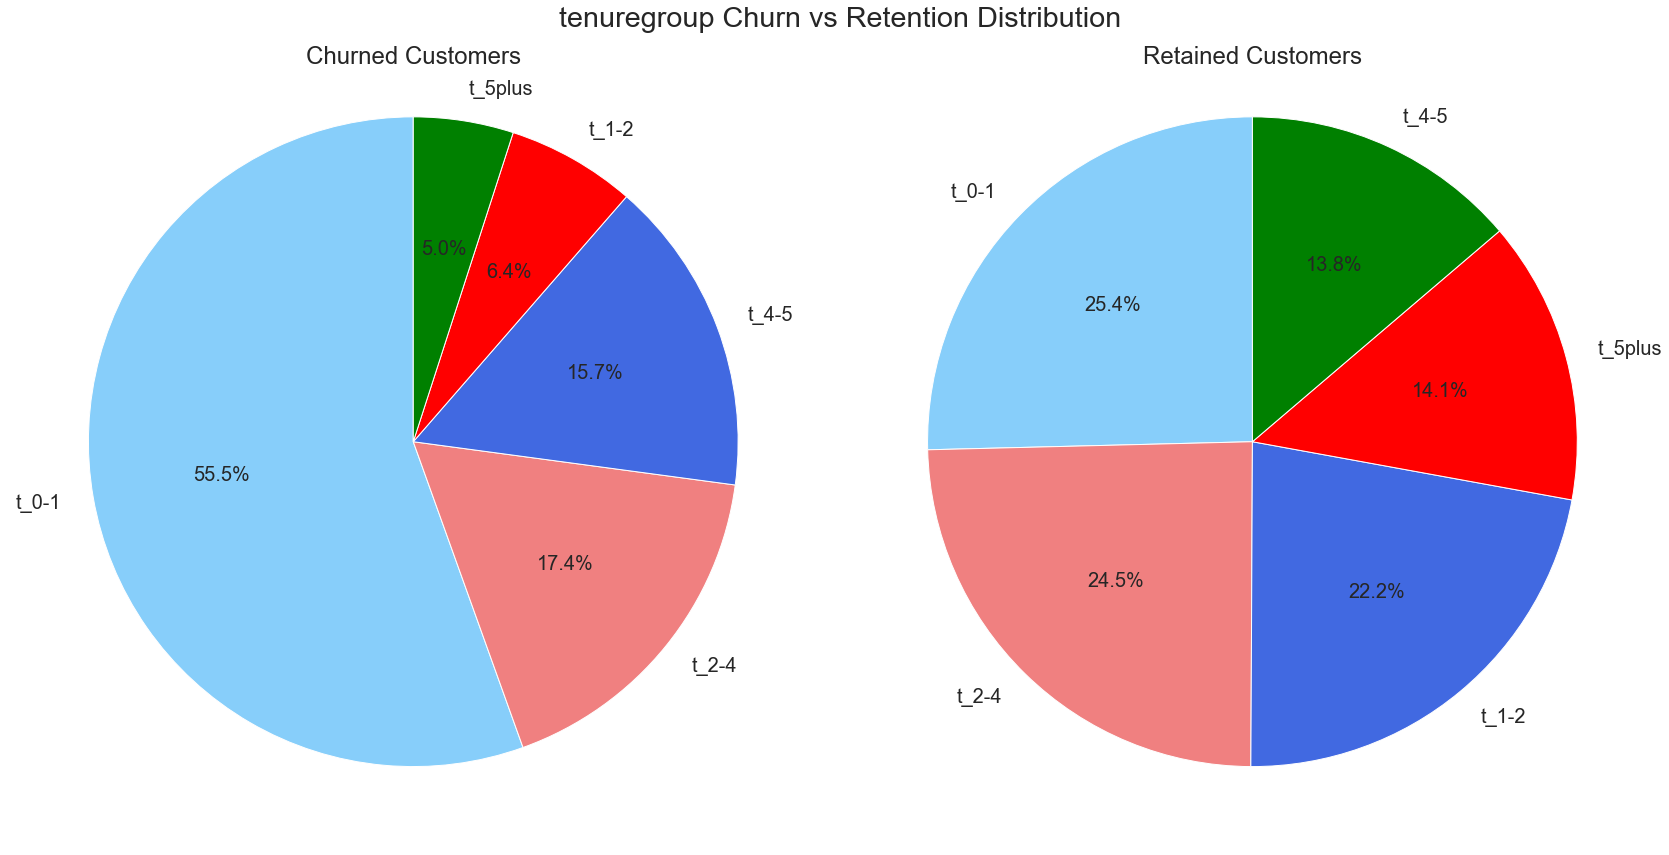

In [32]:
for col in cat_columns:
    category_plots(col)

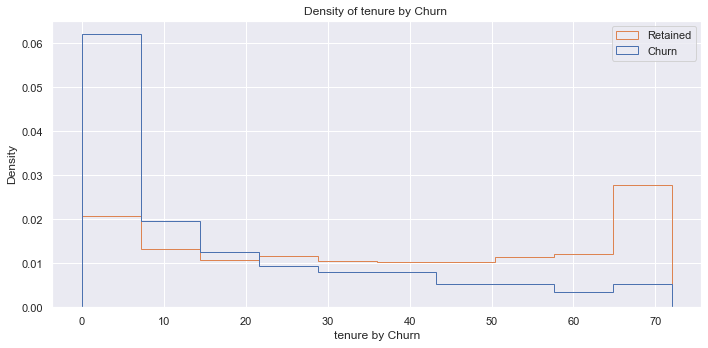

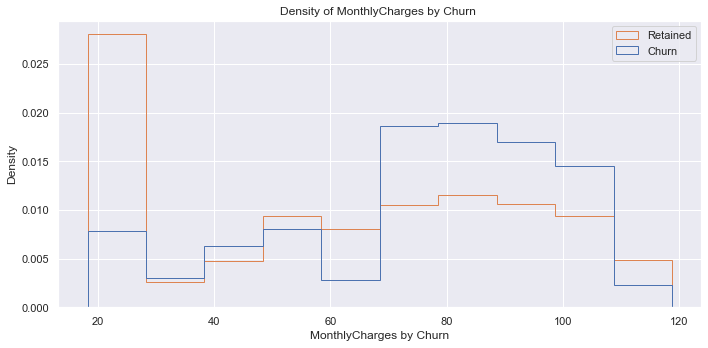

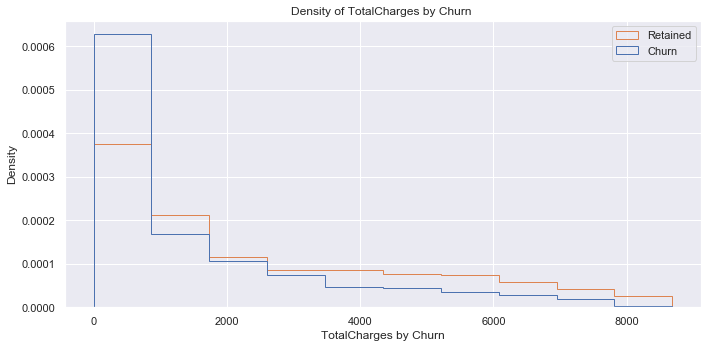

In [33]:
sns.set(font_scale=1)
def continuous_plots(colname):
    churn = churn_customers[colname]
    nochurn = nochurn_customers[colname]

    #Stack the data
    plt.figure(figsize=(10,5))
    plt.hist([churn,nochurn], bins = 10, stacked=False, density=True, label=["Churn","Retained"], histtype="step")
 
    plt.title(f"Density of {colname} by Churn ", {'verticalalignment': 'baseline', 'horizontalalignment': "center"})
    plt.xlabel(f"{colname} by Churn")
    plt.ylabel("Density")
    plt.legend(loc='upper right')
    plt.tight_layout()
    
    plt.show()
    
for col in num_columns:
    continuous_plots(col)

## Bivariate Summary Statistics & Visualizations

In [34]:
# Create a Scatter Matrix
scatter_matrix_df = telecom[["tenure", "MonthlyCharges","TotalCharges", "Churn", "tenuregroup"]]
scatter_matrix_df

tenure  MonthlyCharges  TotalCharges Churn tenuregroup
0          1           29.85     29.850000    No       t_0-1
1         34           56.95   1889.500000    No       t_2-4
2          2           53.85    108.150002   Yes       t_0-1
3         45           42.30   1840.750000    No       t_2-4
4          2           70.70    151.649994   Yes       t_0-1
5          8           99.65    820.500000   Yes       t_0-1
6         22           89.10   1949.400024    No       t_1-2
7         10           29.75    301.899994    No       t_0-1
8         28          104.80   3046.050049   Yes       t_2-4
9         62           56.15   3487.949951    No     t_5plus
10        13           49.95    587.450012    No       t_1-2
11        16           18.95    326.799988    No       t_1-2
12        58          100.35   5681.100098    No       t_4-5
13        49          103.70   5036.299805   Yes       t_4-5
14        25          105.50   2686.050049    No       t_2-4
15        69          113.25   7895.149902    No     t_5plus
16        52           20.65   1022.950012    No       t_4-5
17        71          106.70   7382.250000    No     t_5plus
18        10           55.20    528.349976   Yes       t_0-1
19        21           90.05   1862.900024    No       t_1-2
20         1           39.65     39.650002   Yes       t_0-1
21        12           19.80    202.250000    No       t_0-1
22         1           20.15     20.150000   Yes       t_0-1
23        58           59.90   3505.100098    No       t_4-5
24        49           59.60   2970.300049    No       t_4-5
25        30           55.30   1530.599976    No       t_2-4
26        47           99.35   4749.149902   Yes       t_2-4
27         1           30.20     30.200001   Yes       t_0-1
28        72           90.25   6369.450195    No     t_5plus
29        17           64.70   1093.099976   Yes       t_1-2
30        71           96.35   6766.950195    No     t_5plus
31         2           95.50    181.649994    No       t_0-1
32        27           66.15   1874.449951    No       t_2-4
33         1           20.20     20.200001    No       t_0-1
34         1           45.25     45.250000    No       t_0-1
35        72           99.90   7251.700195    No     t_5plus
36         5           69.70    316.899994   Yes       t_0-1
37        46           74.80   3548.300049    No       t_2-4
38        34          106.35   3549.250000   Yes       t_2-4
39        11           97.85   1105.400024   Yes       t_0-1
40        10           49.55    475.700012    No       t_0-1
41        70           69.20   4872.350098    No     t_5plus
42        17           20.75    418.250000    No       t_1-2
43        63           79.85   4861.450195    No     t_5plus
44        13           76.20    981.450012    No       t_1-2
45        49           84.50   3906.699951    No       t_4-5
46         2           49.25     97.000000    No       t_0-1
47         2           80.65    144.149994   Yes       t_0-1
48        52           79.75   4217.799805    No       t_4-5
49        69           64.15   4254.100098    No     t_5plus
...      ...             ...           ...   ...         ...
6993      50           88.05   4367.350098   Yes       t_4-5
6994      43           24.45    993.150024    No       t_2-4
6995      57           89.55   5012.350098    No       t_4-5
6996      41           66.50   2728.600098   Yes       t_2-4
6997      27           76.10   2093.399902    No       t_2-4
6998      13           80.50   1011.799988    No       t_1-2
6999       3           35.45    106.849998   Yes       t_0-1
7000      67           20.55   1343.400024    No     t_5plus
7001       3           49.90    130.100006   Yes       t_0-1
7002      64          105.40   6794.750000    No     t_5plus
7003      26           35.75   1022.500000    No       t_2-4
7004      38           95.10   3691.199951    No       t_2-4
7005      23           19.30    486.200012    No       t_1-2
7006      40          104.50   4036.85009

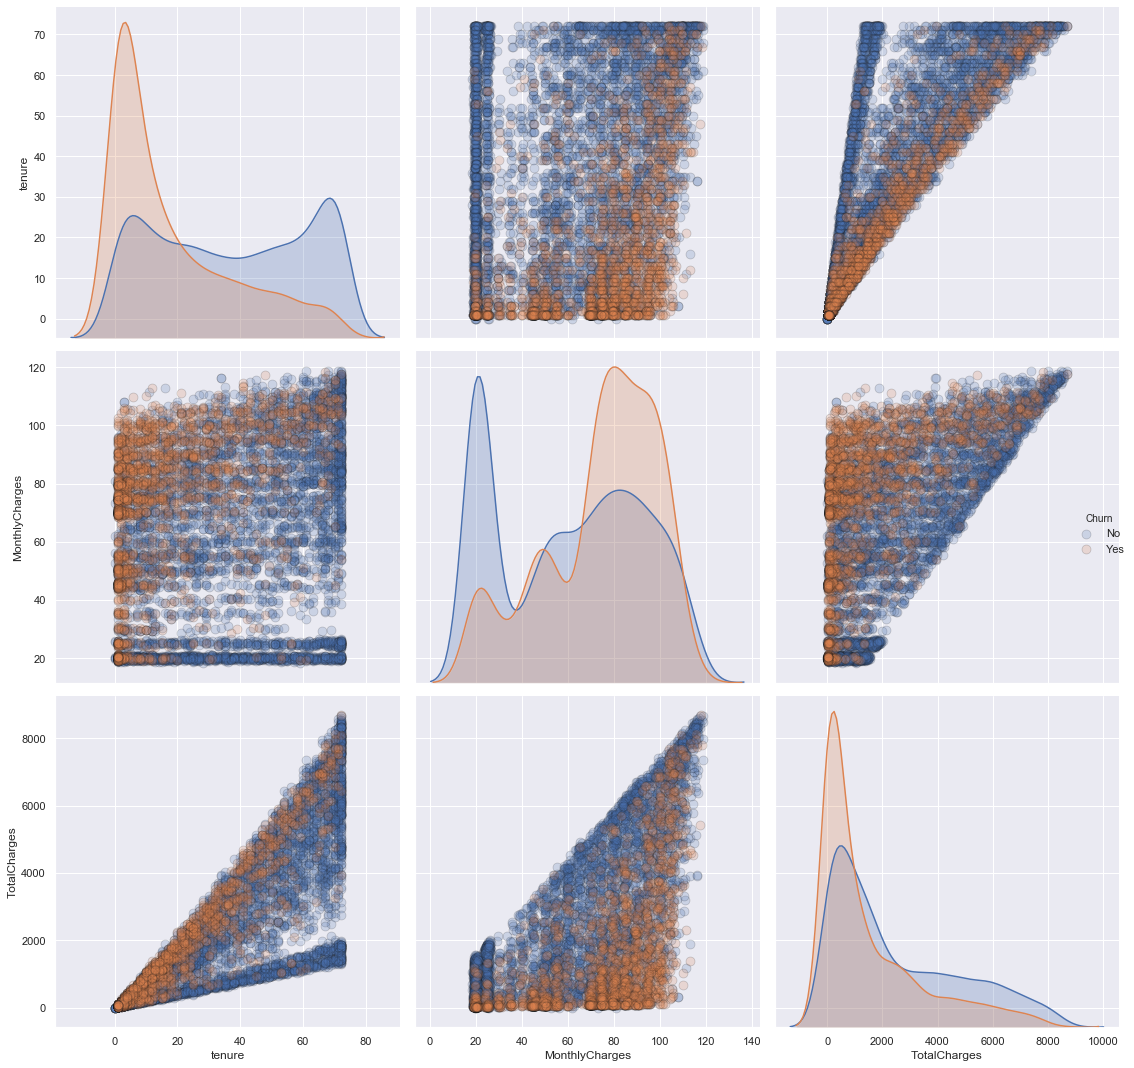

In [35]:
sns.pairplot(scatter_matrix_df, hue = "Churn", diag_kind = "kde",
             plot_kws = {"alpha": 0.2, "s": 80, "edgecolor": "k"},
             height = 5)

plt.tight_layout()

## Obs: There is a strong relationship between:
##       1. MonthlyCharges and TotalCharges
##       2. tenure and TotalCharges
##      The KDEs suggest the density by Churn for each of the continuous variables, which confirms above plots

In [36]:
# Statistics by tenuregroup
churned_tenuregroup = churn_customers.tenuregroup.value_counts().reset_index()
churned_tenuregroup.columns = ["churn_tenuregroup", "frequency"]
#churned_tenuregroup["pct"] = churned_tenuregroup["frequency"]/(churned_tenuregroup["frequency"].sum())*100

churned_tenuregroup

churn_tenuregroup  frequency
0             t_0-1       1037
1             t_2-4        325
2             t_1-2        294
3             t_4-5        120
4           t_5plus         93

In [37]:
retained_tenuregroup = nochurn_customers.tenuregroup.value_counts().reset_index()
retained_tenuregroup.columns = ["retain_tenuregroup", "frequency"]
#retained_tenuregroup["pct"] = retained_tenuregroup["frequency"]/(retained_tenuregroup["frequency"].sum())*100
retained_tenuregroup

retain_tenuregroup  frequency
0            t_5plus       1314
1              t_2-4       1269
2              t_0-1       1149
3              t_1-2        730
4              t_4-5        712

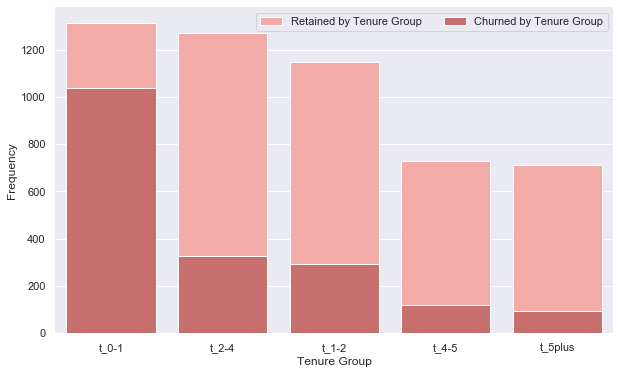

In [38]:
## Plot Churn by Tenure Group

fig, ax1 = plt.subplots(figsize = (10,6))
sns.set_color_codes('pastel')
sns.barplot(x = 'retain_tenuregroup', y = 'frequency', data = retained_tenuregroup,
            label = 'Retained by Tenure Group', color = 'r', edgecolor = 'w')
sns.set_color_codes('muted')
sns.barplot(x = 'churn_tenuregroup', y = 'frequency', data = churned_tenuregroup,
            label = 'Churned by Tenure Group', color = 'r', edgecolor = 'w')
ax1.legend(ncol = 2, loc = 'upper right')
plt.xlabel("Tenure Group")
plt.ylabel("Frequency")
sns.despine(left = True, bottom = True)
plt.show()

## Obs: The newest customers have the Highest Churn by frequency.

In [39]:
telecom.corr()

tenure  MonthlyCharges  TotalCharges
tenure          1.000000        0.247900      0.826178
MonthlyCharges  0.247900        1.000000      0.651174
TotalCharges    0.826178        0.651174      1.000000

In [40]:
telecom_corr = telecom.corr(method="pearson")

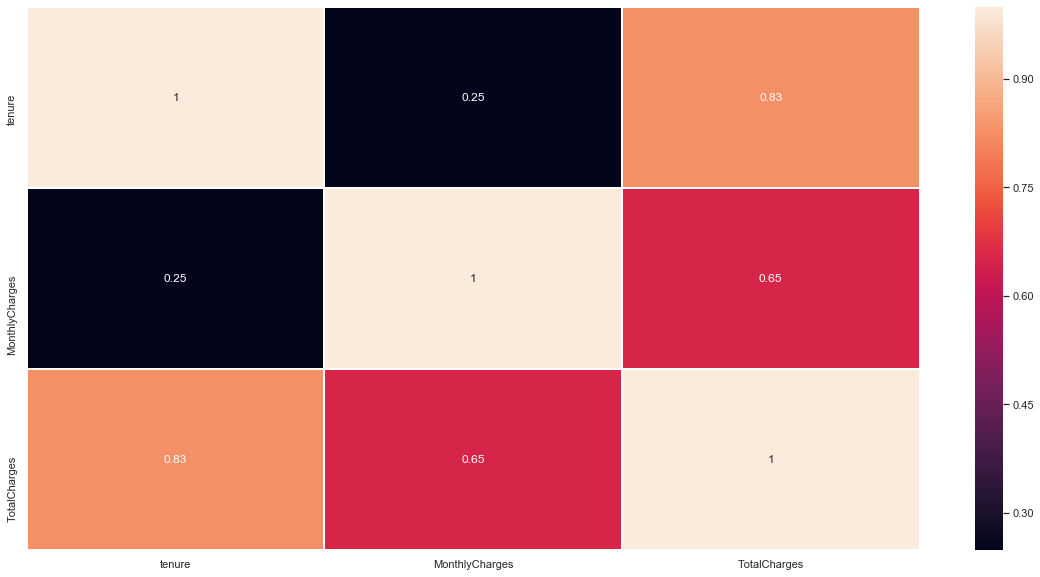

In [41]:
corr_features = telecom.columns.tolist()
corr_array = np.array(telecom_corr)

#Plot Heatmap with annotations using seaborn

sns.set()
f, ax = plt.subplots(figsize=(20,10))
sns.heatmap(telecom_corr, annot=True, linewidth=1, ax=ax)

In [42]:
corr_array = np.array(telecom_corr)
corr_array

## Obs: Confirms the observations made in Scatter Plot matrix for continuous features

array([[1.        , 0.24789986, 0.8261784 ],
       [0.24789986, 1.        , 0.65117383],
       [0.8261784 , 0.65117383, 1.        ]])

## Data Pre-processing for further analysis

##### Since the continuous variables have a wide range and different units of measure, it needs to be transformed to a similar Scale for better comparison
##### Can choose between StandardScaler or MinMaxScaler, 
#####       - Outliers have more impact on StandardScaler than MinMaxScaler, but since there are no outliers in the continuous variables Std. Scaler                     is used
##### But Logistic regression fits a model that use a weighted sum of input variables are affected by difference in scale
https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

#### 1.1. Perform Label Encoding for binary categorical features
#### 1.2. Perform One Hot Encoding for non-binary categorical features
#### 1.3. Perform Data Standardization by Scaling continuous features

In [43]:
telecom.head()

customerID  gender SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female             0     Yes         No       1           No   
1  5575-GNVDE    Male             0      No         No      34          Yes   
2  3668-QPYBK    Male             0      No         No       2          Yes   
3  7795-CFOCW    Male             0      No         No      45           No   
4  9237-HQITU  Female             0      No         No       2          Yes   

  MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0            No             DSL             No          Yes               No   
1            No             DSL            Yes           No              Yes   
2            No             DSL            Yes          Yes               No   
3            No             DSL            Yes           No              Yes   
4            No      FiberOptic             No           No               No   

  TechSupport StreamingTV StreamingMovies Contract PaperlessBilling  \
0          No          No              No  Monthly              Yes   
1          No          No              No      1yr               No   
2          No          No              No  Monthly              Yes   
3         Yes          No              No      1yr               No   
4          No          No              No  Monthly              Yes   

      PaymentMethod  MonthlyCharges  TotalCharges Churn tenuregroup  
0            ECheck           29.85     29.850000    No       t_0-1  
1            MCheck           56.95   1889.500000    No       t_2-4  
2            MCheck           53.85    108.150002   Yes       t_0-1  
3  AutoBankTransfer           42.30   1840.750000    No       t_2-4  
4            ECheck           70.70    151.649994   Yes       t_0-1

In [44]:
original_telecom = telecom.copy(deep=True) # Save original dataframe for future references

In [45]:
# List Label and One Hot Encoding features

le_columns = [] # features with exactly 2 values 
oh_columns = [] # features with more than 2 values and non-ordinal values
id_col = ["customerID"]
target_col = ["Churn"]

le_columns = telecom.nunique()[telecom.nunique()==2].keys().tolist()
oh_columns = [x for x in cat_columns if x not in le_columns]

In [46]:
# Confirm feature levels for the features
telecom[le_columns].nunique()

gender              2
SeniorCitizen       2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       2
OnlineSecurity      2
OnlineBackup        2
DeviceProtection    2
TechSupport         2
StreamingTV         2
StreamingMovies     2
PaperlessBilling    2
Churn               2
dtype: int64

In [47]:
telecom[oh_columns].nunique()

InternetService    3
Contract           3
PaymentMethod      4
tenuregroup        5
dtype: int64

### Perform Transformations to important features

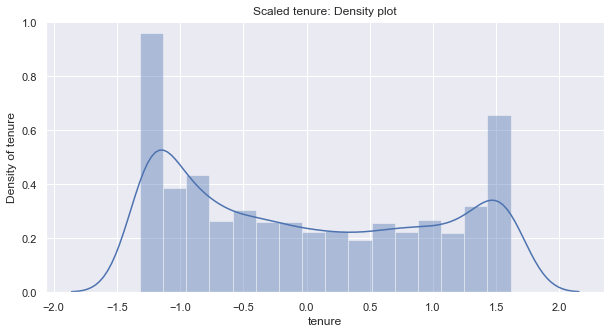

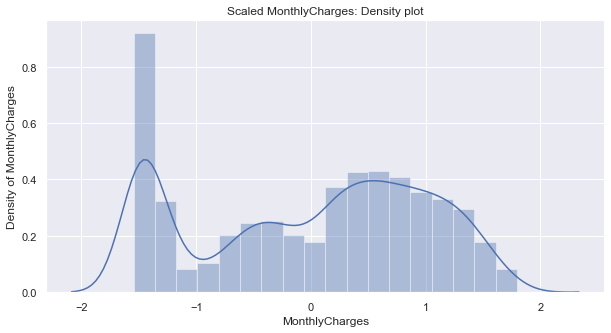

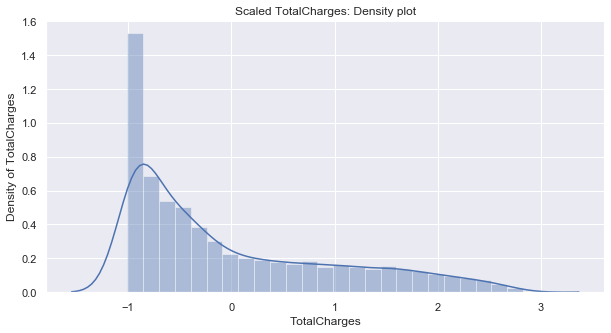

In [48]:
# Perform transformations

le_encode = LabelEncoder()

for l in le_columns:
    telecom[l] = le_encode.fit_transform(telecom[l])
    
#get_dummies for one hot encoding

telecom = pd.get_dummies(data = telecom, columns = oh_columns)

#Scaling Numerical Columns
std = StandardScaler()
scaled = std.fit_transform(telecom[num_columns])
scaled = pd.DataFrame(scaled, columns = num_columns)

for col in scaled.columns:
    plt.figure(figsize=(10,5))    
    plt.tight_layout()
    sns.distplot(scaled[col], kde=True, hist=True).set_title(f"Scaled {col}: Density plot")
    plt.ylabel(f"Density of {col}")

## Obs: The density distribution for the scaled dataset is similar to the original continuous features
## Running this cell again will result in errors, since the telecom df is already transformed

In [49]:
# Compare original and transformed dataset for an example observation
telecom[telecom["customerID"]=="7590-VHVEG"]

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG       0              0        1           0       1   

   PhoneService  MultipleLines  OnlineSecurity  OnlineBackup  \
0             0              0               0             1   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
0                 0            0            0                0   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  InternetService_DSL  \
0                 1           29.85         29.85      0                    1   

   InternetService_FiberOptic  InternetService_No  Contract_1yr  Contract_2yr  \
0                           0                   0             0             0   

   Contract_Monthly  PaymentMethod_AutoBankTransfer  \
0                 1                               0   

   PaymentMethod_AutoCreditCard  PaymentMethod_ECheck  PaymentMethod_MCheck  \
0                             0                     1                     0   

   tenuregroup_t_0-1  tenuregroup_t_1-2  tenuregroup_t_2-4  tenuregroup_t_4-5  \
0                  1                  0                  0                  0   

   tenuregroup_t_5plus  
0                    0

In [50]:
original_telecom[original_telecom["customerID"]=="7590-VHVEG"]

customerID  gender SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female             0     Yes         No       1           No   

  MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0            No             DSL             No          Yes               No   

  TechSupport StreamingTV StreamingMovies Contract PaperlessBilling  \
0          No          No              No  Monthly              Yes   

  PaymentMethod  MonthlyCharges  TotalCharges Churn tenuregroup  
0        ECheck           29.85         29.85    No       t_0-1

In [51]:
# Merge scaled transformed continuous features to the telecom data set & drop original continuous features
#1. Drop old features
telecom = telecom.drop(columns=num_columns, axis=1) 
#2. Add scaled features
telecom = telecom.merge(scaled, left_index=True, right_index=True, how="left")

telecom.head()

customerID  gender  SeniorCitizen  Partner  Dependents  PhoneService  \
0  7590-VHVEG       0              0        1           0             0   
1  5575-GNVDE       1              0        0           0             1   
2  3668-QPYBK       1              0        0           0             1   
3  7795-CFOCW       1              0        0           0             0   
4  9237-HQITU       0              0        0           0             1   

   MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  \
0              0               0             1                 0            0   
1              0               1             0                 1            0   
2              0               1             1                 0            0   
3              0               1             0                 1            1   
4              0               0             0                 0            0   

   StreamingTV  StreamingMovies  PaperlessBilling  Churn  InternetService_DSL  \
0            0                0                 1      0                    1   
1            0                0                 0      0                    1   
2            0                0                 1      1                    1   
3            0                0                 0      0                    1   
4            0                0                 1      1                    0   

   InternetService_FiberOptic  InternetService_No  Contract_1yr  Contract_2yr  \
0                           0                   0             0             0   
1                           0                   0             1             0   
2                           0                   0             0             0   
3                           0                   0             1             0   
4                           1                   0             0             0   

   Contract_Monthly  PaymentMethod_AutoBankTransfer  \
0                 1                               0   
1                 0                               0   
2                 1                               0   
3                 0                               1   
4                 1                               0   

   PaymentMethod_AutoCreditCard  PaymentMethod_ECheck  PaymentMethod_MCheck  \
0                             0                     1                     0   
1                             0                     0                     1   
2                             0                     0                     1   
3                             0                     0                     0   
4                             0                     1                     0   

   tenuregroup_t_0-1  tenuregroup_t_1-2  tenuregroup_t_2-4  tenuregroup_t_4-5  \
0                  1                  0                  0                  0   
1                  0                  0                  1                  0   
2                  1                  0                  0                  0   
3                  0                  0                  1                  0   
4                  1                  0                  0                  0   

   tenuregroup_t_5plus    tenure  MonthlyCharges  TotalCharges  
0                    0 -1.277445       -1.160323     -0.992611  
1                    0  0.066327       -0.259629     -0.172165  
2                    0 -1.236724       -0.362660     -0.958066  
3                    0  0.514251       -0.746535     -0.193672  
4                    0 -1.236724        0.197365     -0.938874

In [ ]:
# Saved the Cleaned, Untransformed data set
file_path = "../data/processed/Telco_Customer_Churn_cleaned.xlsx"

writer = pd.ExcelWriter(file_path, engine = 'xlsxwriter')
original_telecom.to_excel(writer, index = False,sheet_name='Telco_cleaned_NoTransform')
telecom.to_excel(writer, index = False,sheet_name='Telco_TransformedData')
writer.save()
writer.close()

### Create a correlation matrix for transformed data

In [52]:
telecom_corr = telecom.corr(method="pearson")

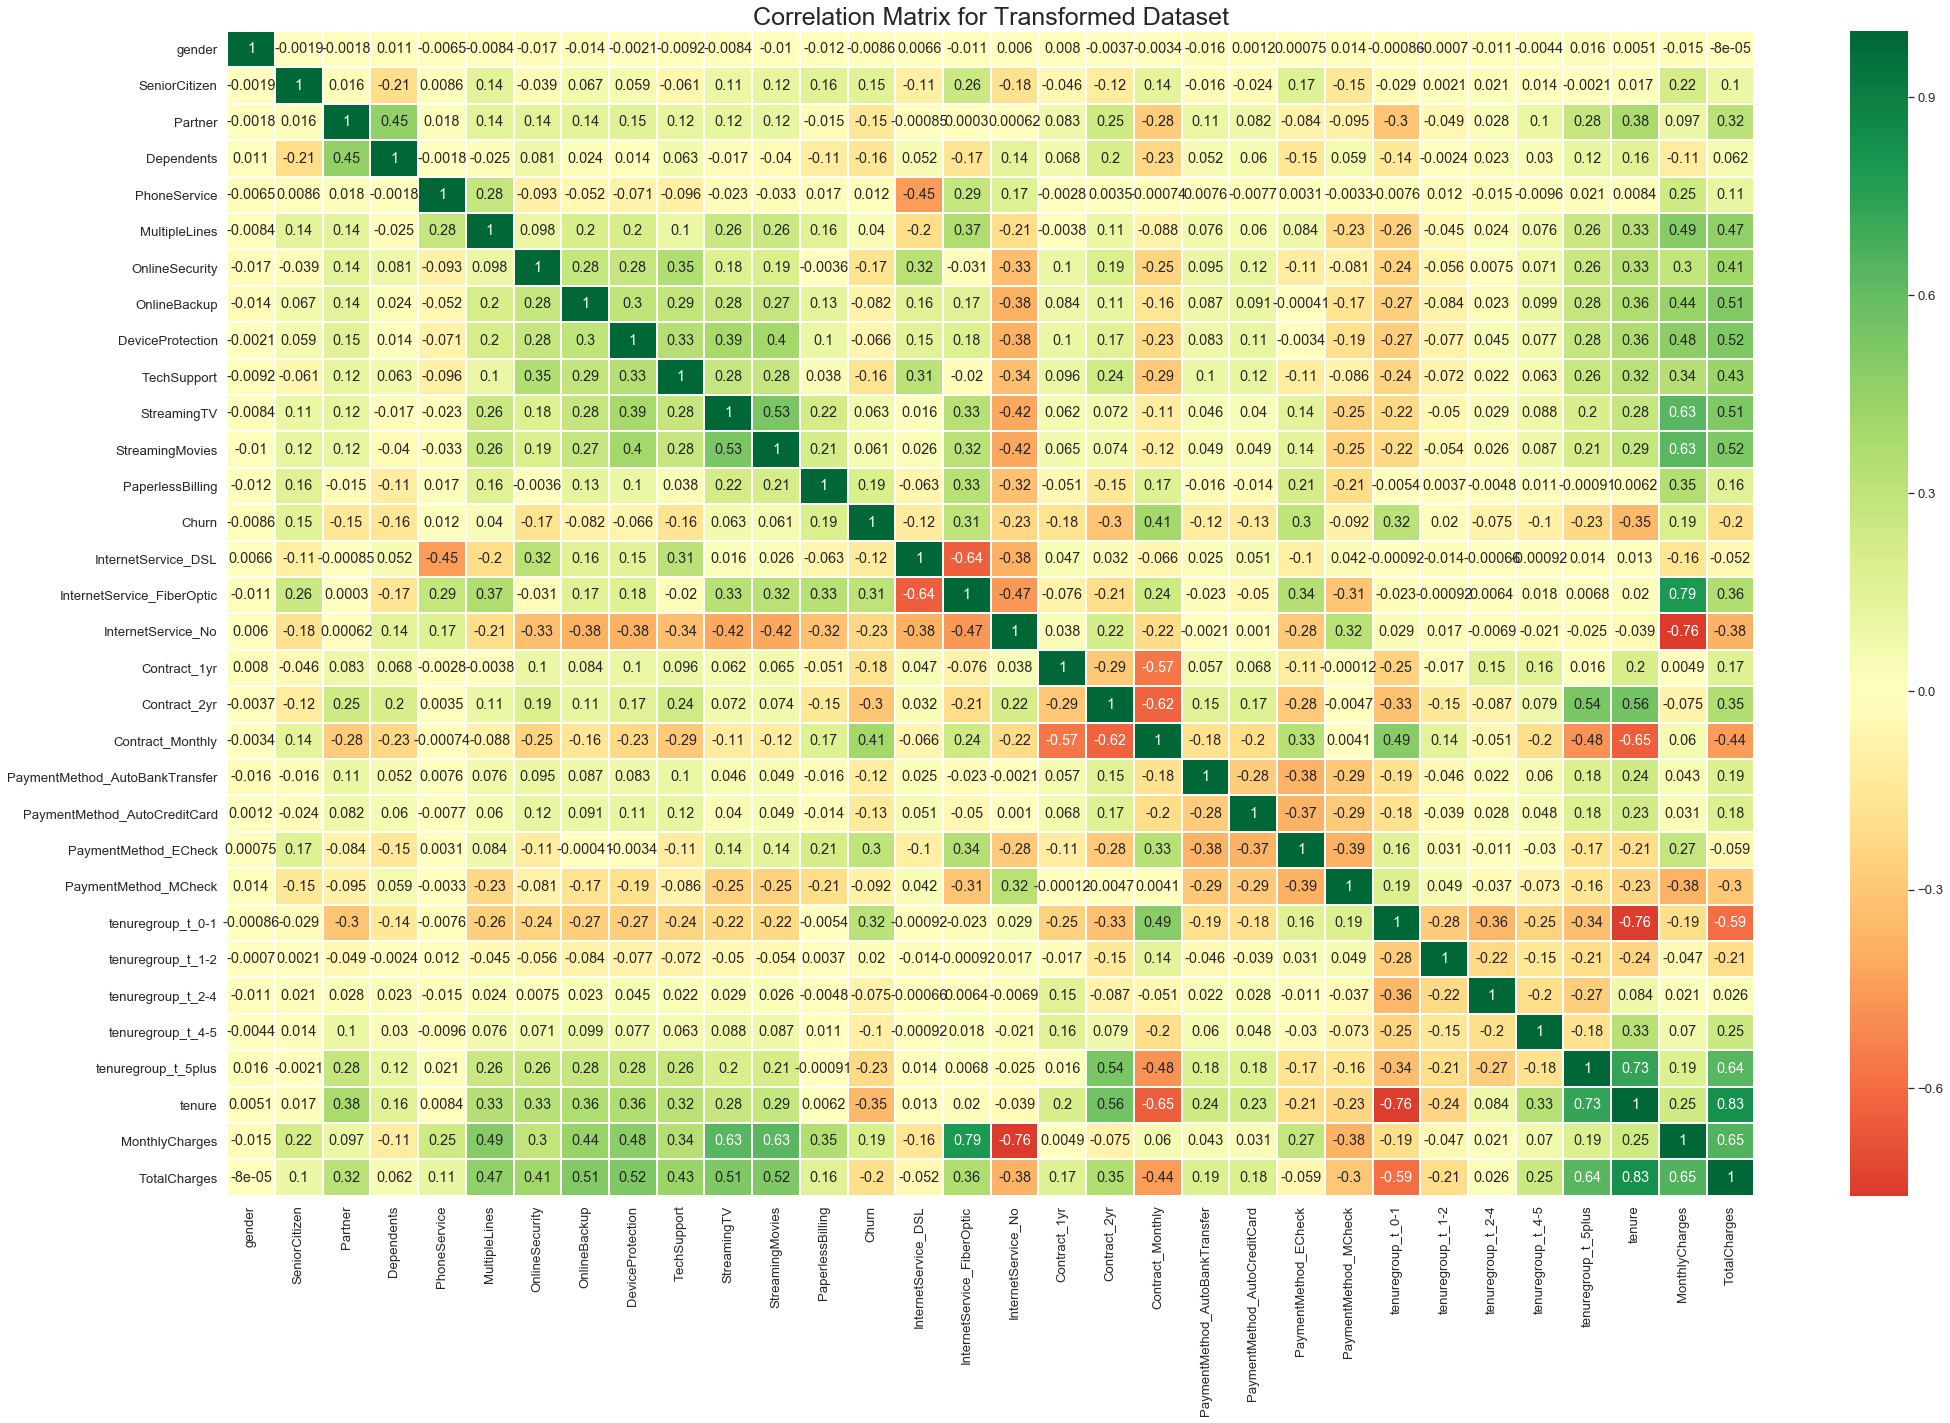

In [53]:
#Plot Heatmap with annotations using seaborn

sns.set(font_scale=1.2)
plt.figure(figsize=(30,20))
sns.heatmap(telecom_corr, annot=True, linewidth=1, center=0, cmap="RdYlGn")
plt.title("Correlation Matrix for Transformed Dataset", fontsize=25)
plt.tight_layout()


# Create Models using Sci-kit Learn for Advanced Analysis & Prediction

## Splitting Data into "Training" and "Test" sub-sets for Model Performance Assessments
### 1. Train-Test Split

In [54]:
# Prepare data for split
telecom_y = []
telecom_y = telecom["Churn"].ravel()
telecom_x = telecom.copy(deep=True)
telecom_x = telecom.drop(columns = ["Churn", "customerID"], axis=1) # Customer ID is not relevant for current analysis

# Split Data
X_train, X_test, y_train, y_test = train_test_split(telecom_x, telecom_y, test_size= 0.25, random_state=0, shuffle=True)

del telecom_y, telecom_x # release memory since these dfs are no longer required

In [55]:
np.nanmean(y_train), np.nanmean(y_test)

#Similar means = the split is not imbalanced

(0.26618705035971224, 0.2629187961385576)

In [56]:
# Define required functions for repeated executions

#1. Get Model Scores

def model_scores(model_name, model, Xtest, ytest, predictions,idx):
    model_acc = model.score(Xtest, ytest)
    model_recall = recall_score(ytest,np.array(predictions))
    model_precision = precision_score(ytest,np.array(predictions))
    model_auc = roc_auc_score(ytest,np.array(predictions))
    model_f1 = f1_score(ytest, np.array(predictions))
    model_classreport = classification_report(ytest, np.array(predictions))
    model_cm = confusion_matrix(ytest, np.array(predictions))
    
    print("\033[1m Classification Report: \033[0;0m\n", model_classreport)
    print("\033[1m Accuracy Score: \033[0;0m\n", model_acc)    
    print(f"\033[1m Precision: \033[0;0m{model_precision}\033[1m  & Recall Scores: \033[0;0m{model_recall}\n")
    print("\033[1m F1 Score: \033[0;0m\n", model_f1)
    print("\033[1m AUC: \033[0;0m\n", model_auc)
    
    comp_cols = ["ModelName", "AccuracyScore", "RecallScore", "PrecisionScore", "F1Score", "AreaUnderCurve" ]
        
    df = []
    df = (pd.DataFrame({"ModelName": model_name, 
                        "AccuracyScore":model_acc,
                        "RecallScore": model_recall,
                        "PrecisionScore": model_precision,
                        "F1Score": model_f1,
                        "AreaUnderCurve": model_auc
                        }, 
                       index=[idx])
         )
        
    plot_confusionmatrix(model_name, model_cm)
    
    fpr, tpr, thresholds = roc_curve(ytest, model.predict_proba(Xtest)[:,1])
    plot_roc_auc(model_name, model_auc, fpr, tpr)
    
    return df
    
    
    
#2. Plot Confusion Matrix for the models
def plot_confusionmatrix(algorithm, conf_matrix):
    classes = ["Retained Customers", "Churn Customers"]
    plt.figure(figsize=(7,7))
    plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"{algorithm}: Confusion Matrix")
    plt. colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)
    fmt = "d"
    thresh = conf_matrix.max()/2

    #Labeling the plot
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
            plt.text(j, i, format(conf_matrix[i, j], fmt), fontsize = 15,
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 15)
    plt.xlabel('Predicted label', size = 15)
    
#3. Plot ROC-AUC Curve
def plot_roc_auc(algorithm, roc_auc, fpr, tpr):
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label="Model (area = %0.2f)" %roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{algorithm} Receiver Operating Characteristic")
    plt.legend(loc="lower right")    
    plt.show()
    

### 1. Create Dummy Baseline Model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Classification Report: 
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      1298
           1       0.00      0.00      0.00       463

    accuracy                           0.74      1761
   macro avg       0.37      0.50      0.42      1761
weighted avg       0.54      0.74      0.63      1761

 Accuracy Score: 
 0.7370812038614424
 Precision: 0.0  & Recall Scores: 0.0

 F1 Score: 
 0.0
 AUC: 
 0.5


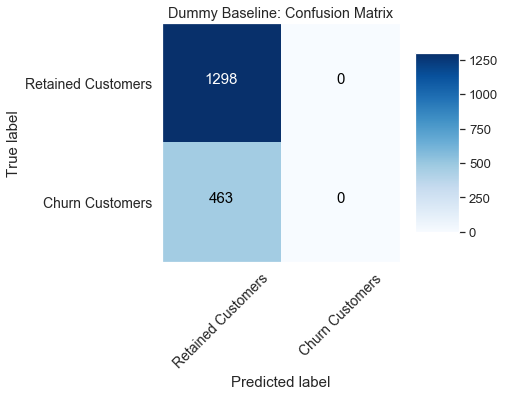

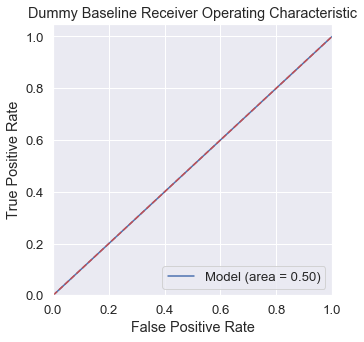

ModelName  AccuracyScore  RecallScore  PrecisionScore  F1Score  \
0  Dummy Baseline       0.737081          0.0             0.0      0.0   

   AreaUnderCurve  
0             0.5

In [57]:
dummy_model = DummyClassifier(strategy="most_frequent", random_state=0)

# Train Dummy Baseline
dummy_model.fit(X_train, y_train)

#Generate Prediction
base_predictions = dummy_model.predict(X_test)

# Display Scores & Confusion Matrix
model_comparison = pd.DataFrame(model_scores("Dummy Baseline", dummy_model, X_test, y_test, base_predictions,0), 
                                columns=["ModelName", 
                                         "AccuracyScore", 
                                         "RecallScore", 
                                         "PrecisionScore", 
                                         "F1Score", 
                                         "AreaUnderCurve" ]
                               )
model_comparison.drop_duplicates() # In case this cell is rerun

### Over Sampling the train sets using SMOTE (Synthetic Minority Oversampling Technique)
###   - Up sample "Churned Customers" in the training dataset

In [58]:
x_cols = X_train.columns.tolist()
y_cols = ["Churn"]

In [59]:
#oversampling minority class using smote

over_sample = SMOTE(random_state = 0)

os_data_X, os_data_y = over_sample.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X, columns=x_cols)
os_data_y = pd.DataFrame(data=os_data_y, columns=y_cols)

#Check the details after SMOTE runs
retain_count = len(os_data_y[os_data_y["Churn"]==0])
churn_count = len(os_data_y[os_data_y["Churn"]==1])

print(f"Total count of Oversampled data: {len(os_data_X)}")
print(f"Number of Retained Customer count in Oversample data: {retain_count}")
print(f"Number of Churned Customer count in Oversample data: {churn_count}")
print(f"Proportion of Retained Customer data: {retain_count/len(os_data_X)}")
print(f"Proportion of Churned Customer data: {churn_count/len(os_data_X)}")

Total count of Oversampled data: 7752
Number of Retained Customer count in Oversample data: 3876
Number of Churned Customer count in Oversample data: 3876
Proportion of Retained Customer data: 0.5
Proportion of Churned Customer data: 0.5


In [ ]:
## Obs: Imbalanced classes from the target variable has been addressed and these data sets are to be used for further modelling

### Dimension Reduction - Remove features which would not contribute to the model's performance
### Use RFE (Recursive Feature Elimination)
####   - Repeatedly construct a model and choose either the best or worst performing feature

In [60]:
# Create RFE Model
# use x_cols and y_cols from above for column information

log_regr = LogisticRegression(solver="liblinear")

rfe = RFE(log_regr, 15) #Select top 15 features from 31 -> try and reduce the # of features by 50% approx.
rfe.fit(os_data_X, os_data_y.values.ravel())
rfe_ranking = pd.DataFrame( {"Features" : X_train.columns.tolist(),
                             "rfe_support": rfe.support_,                             
                             "rfe_ranking": rfe.ranking_})
rfe_ranking.sort_values(by="rfe_ranking", inplace=True)
rfe_ranking

## Obs: Based on the RFE model, we know that out of 31 features, top 15 features are listed below. 
## These can be further reduced based on the p-values for each 

Features  rfe_support  rfe_ranking
22            PaymentMethod_MCheck         True            1
23               tenuregroup_t_0-1         True            1
24               tenuregroup_t_1-2         True            1
21            PaymentMethod_ECheck         True            1
17                    Contract_2yr         True            1
9                      TechSupport         True            1
29                  MonthlyCharges         True            1
18                Contract_Monthly         True            1
6                   OnlineSecurity         True            1
25               tenuregroup_t_2-4         True            1
4                     PhoneService         True            1
19  PaymentMethod_AutoBankTransfer         True            1
20    PaymentMethod_AutoCreditCard         True            1
28                          tenure         True            1
16                    Contract_1yr         True            1
7                     OnlineBackup        False            2
14      InternetService_FiberOptic        False            3
15              InternetService_No        False            4
11                 StreamingMovies        False            5
10                     StreamingTV        False            6
8                 DeviceProtection        False            7
26               tenuregroup_t_4-5        False            8
27             tenuregroup_t_5plus        False            9
30                    TotalCharges        False           10
5                    MultipleLines        False           11
13             InternetService_DSL        False           12
3                       Dependents        False           13
0                           gender        False           14
12                PaperlessBilling        False           15
2                          Partner        False           16
1                    SeniorCitizen        False           17

In [61]:
# Output top 15 columns from RFE process
rfe_cols = rfe_ranking[rfe_ranking["rfe_support"] == True]["Features"].tolist()

# Build new training dataframes with the above selected columns
X = os_data_X[rfe_cols]
y = os_data_y

### Implementing Stats Model to get the p-values of each of the selected columns

In [296]:
stats_logitmodel = sm.Logit(y, X.drop(columns="tenure",axis=1))
result = stats_logitmodel.fit()
print("Summary: \n",result.summary2())

Optimization terminated successfully.
         Current function value: 0.451591
         Iterations 7
Summary: 
                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:      0.348    
Dependent Variable:      Churn                 AIC:                   7021.4669
Date:                    2020-07-26 13:10      BIC:                   7091.0239
No. Observations:        7752                  Log-Likelihood:        -3500.7  
Df Model:                9                     LL-Null:               -5373.3  
Df Residuals:            7742                  LLR p-value:           0.0000   
Converged:               1.0000                Scale:                 1.0000   
No. Iterations:          7.0000                                                
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------

In [63]:
# Remove columns with p-value more than significance value of 0.05
remove_cols = ["tenuregroup_t_1-2","Contract_2yr", "tenuregroup_t_2-4", "PhoneService"]
final_cols = [i for i in X.columns if i not in remove_cols]

X = os_data_X[final_cols]
y = os_data_y["Churn"]

print(f"Total number of Observations in Oversampled X: {len(X)} & Oversampled y: {len(y)}")

Total number of Observations in Oversampled X: 7752 & Oversampled y: 7752


#### Make sure the p-values are correct for remaining features

In [64]:
stats_logitmodel = sm.Logit(y, X)
result = stats_logitmodel.fit()
print("Summary: \n",result.summary2())

Optimization terminated successfully.
         Current function value: 0.447988
         Iterations 7
Summary: 
                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:      0.354    
Dependent Variable:      Churn                 AIC:                   6967.6048
Date:                    2020-07-24 11:39      BIC:                   7044.1176
No. Observations:        7752                  Log-Likelihood:        -3472.8  
Df Model:                10                    LL-Null:               -5373.3  
Df Residuals:            7741                  LLR p-value:           0.0000   
Converged:               1.0000                Scale:                 1.0000   
No. Iterations:          7.0000                                                
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------

# Build Logistic Regression Model with Default Parameters

 Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       984
           1       0.79      0.80      0.80       954

    accuracy                           0.80      1938
   macro avg       0.80      0.80      0.80      1938
weighted avg       0.80      0.80      0.80      1938

 Accuracy Score: 
 0.7982456140350878
 Precision: 0.7941483803552769  & Recall Scores: 0.7966457023060797

 F1 Score: 
 0.7953950811093669
 AUC: 
 0.7982212251367797


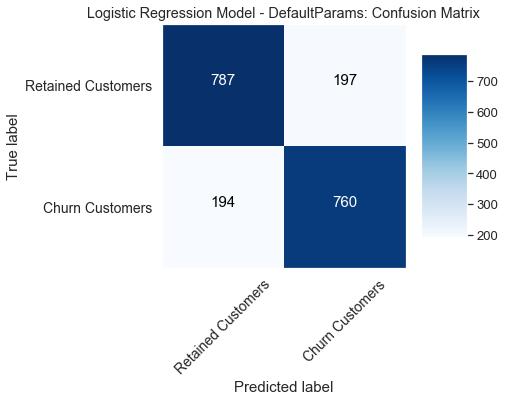

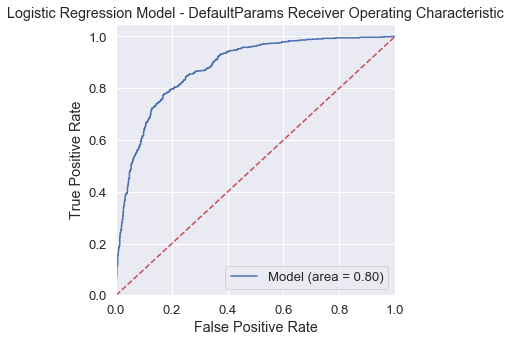

ModelName  AccuracyScore  RecallScore  \
0                             Dummy Baseline       0.737081     0.000000   
1  Logistic Regression Model - DefaultParams       0.798246     0.796646   

   PrecisionScore   F1Score  AreaUnderCurve  
0        0.000000  0.000000        0.500000  
1        0.794148  0.795395        0.798221

In [65]:
# Split the oversampled "balanced" training data set again, since the old training data was imbalanced.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size= 0.25, random_state=0)

# Create Logistic Regression model with Default parameters
lr_model = LogisticRegression(solver="liblinear")

# Train the model
lr_model.fit(X_train, y_train)

# Predict the results from testing set & calculate model performance
lr_predictions = lr_model.predict(X_test)


model_comparison = model_comparison.append(model_scores(model_name = "Logistic Regression Model - DefaultParams", 
                                                        model = lr_model, 
                                                        Xtest = X_test,
                                                        ytest = y_test, 
                                                        predictions = lr_predictions, 
                                                        idx=1),
                                           ignore_index=False)

model_comparison = model_comparison.drop_duplicates() #Incase this cell is run again. 
model_comparison

In [269]:
## Obs: The Scores are Far better than the dummy baseline model 

cv_model.best_estimator_.coef_

array([[-7.63536385,  0.59448836, -6.97916013, -0.8919896 ,  0.95041046,
         0.99979946, -1.00060073, -7.6572717 , -7.76019572, -0.61380111,
        -0.06921274]])

### Hyperparameter tuning for Logistic Regression Model

In [302]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [306]:
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.65, 0:0.3}, {1:0.7, 0:0.3}]
parameters = {"C": [0.01, 0.1, 1, 10, 100, 1000],
              "penalty": ["l1", "l2"], 
              "class_weight": class_weight, 
              "solver" : ['liblinear', 'saga']}

cv_model = GridSearchCV(lr_model, 
                        param_grid = parameters, 
                        cv = 3, 
                        scoring="recall",
                        verbose=1, 
                        n_jobs=-1) # perform 3 fold validation

cv_result = cv_model.fit(X_train, y_train)

print(f"Best Parameters: {cv_model.best_params_} \n")
print(f"Best Score after HPO: {cv_model.best_score_} \n")
print(f"Best Model Accuracy Score after Hyperparameter Optimization: {cv_model.score(X_test, y_test)}")

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.2s


Best Parameters: {'C': 0.01, 'class_weight': {1: 0.7, 0: 0.3}, 'penalty': 'l1', 'solver': 'saga'} 

Best Score after HPO: 0.9613278576317591 

Best Model Accuracy Score after Hyperparameter Optimization: 0.9444444444444444


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    6.0s finished


 Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.43      0.58       984
           1       0.62      0.94      0.75       954

    accuracy                           0.68      1938
   macro avg       0.75      0.69      0.66      1938
weighted avg       0.76      0.68      0.66      1938

 Accuracy Score: 
 0.9444444444444444
 Precision: 0.6175462645647704  & Recall Scores: 0.9444444444444444

 F1 Score: 
 0.7467882304185661
 AUC: 
 0.6886856368563685


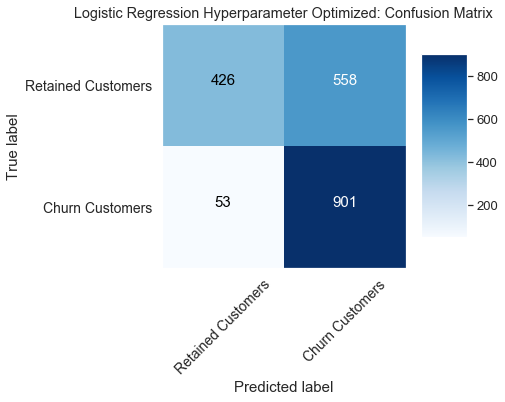

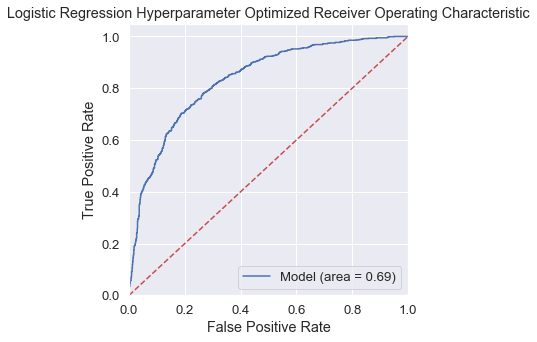

ModelName  AccuracyScore  RecallScore  \
0                                Dummy Baseline       0.737081     0.000000   
1     Logistic Regression Model - DefaultParams       0.798246     0.796646   
2  Logistic Regression Hyperparameter Optimized       0.881613     0.745283   
3                         Random Forest Default       0.789990     0.797694   
4                      Random Forest HyperTuned       0.807534     0.829140   
2  Logistic Regression Hyperparameter Optimized       1.000000     1.000000   
3                         Random Forest Default       0.832817     0.861635   
4                      Random Forest HyperTuned       0.818369     0.855346   
3                         Random Forest Default       0.839525     0.866876   
4                      Random Forest HyperTuned       0.813209     0.853249   
4                      Random Forest HyperTuned       0.813725     0.848008   
2  Logistic Regression Hyperparameter Optimized       0.799278     0.795597   
2  Logistic Regression Hyperparameter Optimized       0.944444     0.944444   

   PrecisionScore   F1Score  AreaUnderCurve  
0        0.000000  0.000000        0.500000  
1        0.794148  0.795395        0.798221  
2        0.826744  0.783903        0.796930  
3        0.780513  0.789010        0.790107  
4        0.790210  0.809207        0.807863  
2        0.492260  0.659751        0.500000  
3        0.810651  0.835366        0.833257  
4        0.792233  0.822581        0.818933  
3        0.818002  0.841730        0.839942  
4        0.785714  0.818090        0.813820  
4        0.789268  0.817585        0.814248  
2        0.796432  0.796015        0.799222  
2        0.617546  0.746788        0.688686

In [307]:
cv_predictions = cv_model.predict(X_test)
model_comparison = model_comparison.append(model_scores(model_name="Logistic Regression Hyperparameter Optimized",
                                     model = cv_model,
                                     Xtest = X_test,
                                     ytest = y_test,
                                     predictions = cv_predictions,
                                     idx = 2),
                       ignore_index = False)

model_comparison.drop_duplicates()
model_comparison

# Build Random Forest Model with Default Parameters

In [68]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X, y)

RandomForestClassifier(max_features='sqrt')

In [282]:
# Prepare data for split
telecom_y = []
telecom_y = os_data_y["Churn"]
telecom_y = telecom_y.ravel()

#telecom_x = os_data_X[final_cols] # work with only important features
#try with entire data set
telecom_x = os_data_X
telecom_x = telecom_x.drop(columns="tenure", axis=1)

# Split Data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(telecom_x, 
                                                                telecom_y, 
                                                                test_size= 0.25, 
                                                                random_state=0, 
                                                                shuffle=True)

In [283]:
X_train_rf.head()

gender  SeniorCitizen  Partner  Dependents  PhoneService  MultipleLines  \
2100       1              1        1           0             1              1   
3490       0              0        1           1             1              1   
7444       0              1        0           0             1              0   
4193       1              0        1           1             0              0   
1715       1              0        0           0             0              0   

      OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  \
2100               0             1                 1            1   
3490               1             0                 1            1   
7444               0             0                 0            0   
4193               0             1                 0            0   
1715               0             0                 0            0   

      StreamingTV  StreamingMovies  PaperlessBilling  InternetService_DSL  \
2100            1                1                 1                    0   
3490            1                1                 1                    1   
7444            0                0                 1                    0   
4193            1                1                 1                    1   
1715            1                0                 1                    1   

      InternetService_FiberOptic  InternetService_No  Contract_1yr  \
2100                           1                   0             0   
3490                           0                   0             0   
7444                           1                   0             0   
4193                           0                   0             1   
1715                           0                   0             0   

      Contract_2yr  Contract_Monthly  PaymentMethod_AutoBankTransfer  \
2100             1                 0                               1   
3490             1                 0                               0   
7444             0                 1                               0   
4193             0                 0                               1   
1715             0                 1                               0   

      PaymentMethod_AutoCreditCard  PaymentMethod_ECheck  \
2100                             0                     0   
3490                             0                     1   
7444                             0                     1   
4193                             0                     0   
1715                             1                     0   

      PaymentMethod_MCheck  tenuregroup_t_0-1  tenuregroup_t_1-2  \
2100                     0                  0                  0   
3490                     0                  0                  0   
7444                     0                  0                  1   
4193                     0                  0                  0   
1715                     0                  1                  0   

      tenuregroup_t_2-4  tenuregroup_t_4-5  tenuregroup_t_5plus  \
2100                  0                  0                    1   
3490                  0                  1                    0   
7444                  0                  0                    0   
4193                  0                  1                    0   
1715                  0                  0                    0   

      MonthlyCharges  TotalCharges  
2100        1.450360      2.222885  
3490        0.656021      1.131928  
7444        0.313396     -0.524211  
4193       -0.430794      0.115376  
1715       -0.999129     -0.875146

In [284]:
# Create the model with 100 trees
rf_model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_features='sqrt')

In [285]:
rf_pred = rf_model.predict(X_test_rf)

In [286]:
rf_model.feature_importances_

array([0.02667754, 0.01596089, 0.02451939, 0.02615495, 0.0072044 ,
       0.01751907, 0.02897201, 0.02416371, 0.01918295, 0.02683212,
       0.01713653, 0.01734694, 0.02225032, 0.01503272, 0.03635187,
       0.02351801, 0.02031881, 0.0443118 , 0.0979114 , 0.01249931,
       0.01377315, 0.04061005, 0.01269924, 0.03907769, 0.00872035,
       0.01233196, 0.00783221, 0.0144585 , 0.15959537, 0.16703674])

In [ ]:
#y_test_e = le_encode.fit_transform(y_test_rf)
#rf_pred_e = le_encode.fit_transform(rf_pred)

 Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.81      0.84       984
           1       0.82      0.87      0.84       954

    accuracy                           0.84      1938
   macro avg       0.84      0.84      0.84      1938
weighted avg       0.84      0.84      0.84      1938

 Accuracy Score: 
 0.8395252837977296
 Precision: 0.8180019782393669  & Recall Scores: 0.8668763102725366

 F1 Score: 
 0.8417302798982188
 AUC: 
 0.8399422201769187


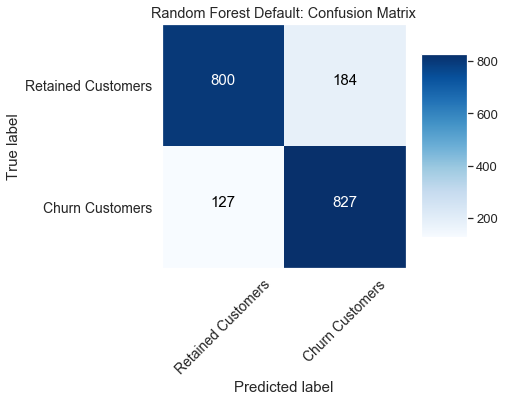

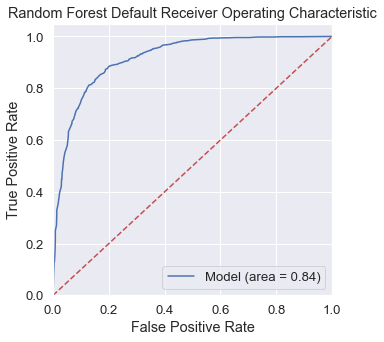

ModelName  AccuracyScore  RecallScore  \
0                                Dummy Baseline       0.737081     0.000000   
1     Logistic Regression Model - DefaultParams       0.798246     0.796646   
2  Logistic Regression Hyperparameter Optimized       0.881613     0.745283   
3                         Random Forest Default       0.789990     0.797694   
4                      Random Forest HyperTuned       0.807534     0.829140   
2  Logistic Regression Hyperparameter Optimized       1.000000     1.000000   
3                         Random Forest Default       0.832817     0.861635   
4                      Random Forest HyperTuned       0.818369     0.855346   
3                         Random Forest Default       0.839525     0.866876   

   PrecisionScore   F1Score  AreaUnderCurve  
0        0.000000  0.000000        0.500000  
1        0.794148  0.795395        0.798221  
2        0.826744  0.783903        0.796930  
3        0.780513  0.789010        0.790107  
4        0.790210  0.809207        0.807863  
2        0.492260  0.659751        0.500000  
3        0.810651  0.835366        0.833257  
4        0.792233  0.822581        0.818933  
3        0.818002  0.841730        0.839942

In [287]:
#model_comparison = model_comparison.drop(index=3, axis=0)
model_comparison = model_comparison.append(model_scores(model_name="Random Forest Default",
                                                           model = rf_model,
                                                           Xtest = X_test_rf,
                                                           ytest = y_test_rf,
                                                           predictions = rf_pred,
                                                           idx = 3),
                                          ignore_index = False)
model_comparison.drop_duplicates()
model_comparison

### Hyperparameter tuning for Random Forest Model

In [293]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000], 
    'max_features': ["sqrt", "log2"]
}

# Instantiate the grid search model
cv_rf_model = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring="recall") # 3-fold validation

#Add , scoring="recall" above later on

In [294]:
# Train the best model; Takes around 10 mins! - Get some coffee :)
cv_rf_model.fit(X_train_rf, y_train_rf)
print("Best Parameters:", cv_rf_model.best_params_)


Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  5.5min finished


Best Parameters: {'bootstrap': True, 'max_depth': 110, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 300}


 Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.78      0.81       984
           1       0.79      0.85      0.82       954

    accuracy                           0.81      1938
   macro avg       0.82      0.81      0.81      1938
weighted avg       0.82      0.81      0.81      1938

 Accuracy Score: 
 0.8137254901960784
 Precision: 0.7892682926829269  & Recall Scores: 0.8480083857442348

 F1 Score: 
 0.8175846387064175
 AUC: 
 0.8142480953111418


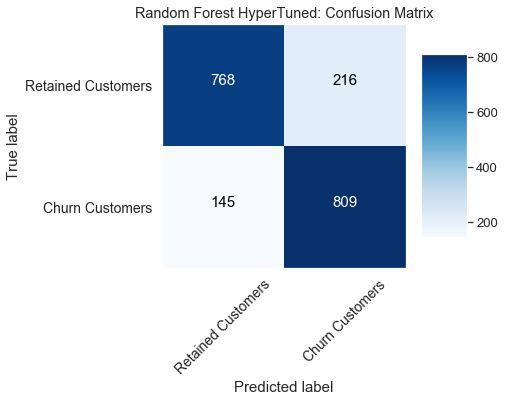

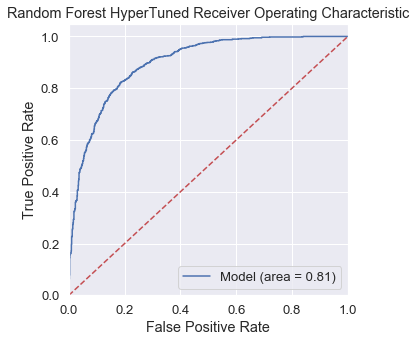

ModelName  AccuracyScore  RecallScore  \
0                                Dummy Baseline       0.737081     0.000000   
1     Logistic Regression Model - DefaultParams       0.798246     0.796646   
2  Logistic Regression Hyperparameter Optimized       0.881613     0.745283   
3                         Random Forest Default       0.789990     0.797694   
4                      Random Forest HyperTuned       0.807534     0.829140   
2  Logistic Regression Hyperparameter Optimized       1.000000     1.000000   
3                         Random Forest Default       0.832817     0.861635   
4                      Random Forest HyperTuned       0.818369     0.855346   
3                         Random Forest Default       0.839525     0.866876   
4                      Random Forest HyperTuned       0.813209     0.853249   
4                      Random Forest HyperTuned       0.813725     0.848008   

   PrecisionScore   F1Score  AreaUnderCurve  
0        0.000000  0.000000        0.500000  
1        0.794148  0.795395        0.798221  
2        0.826744  0.783903        0.796930  
3        0.780513  0.789010        0.790107  
4        0.790210  0.809207        0.807863  
2        0.492260  0.659751        0.500000  
3        0.810651  0.835366        0.833257  
4        0.792233  0.822581        0.818933  
3        0.818002  0.841730        0.839942  
4        0.785714  0.818090        0.813820  
4        0.789268  0.817585        0.814248

In [295]:
best_rf_model = cv_rf_model.best_estimator_
cv_rf_pred = best_rf_model.predict(X_test_rf)

model_comparison = model_comparison.append(model_scores(model_name="Random Forest HyperTuned",
                                                        model = best_rf_model,
                                                        Xtest = X_test_rf,
                                                        ytest = y_test_rf,
                                                        predictions = cv_rf_pred,
                                                        idx = 4), 
                                           ignore_index = False)
model_comparison.drop_duplicates()
model_comparison

feature  importance
18            Contract_Monthly    0.151399
29                TotalCharges    0.124671
28              MonthlyCharges    0.115598
17                Contract_2yr    0.066073
23           tenuregroup_t_0-1    0.058995
14  InternetService_FiberOptic    0.054404
21        PaymentMethod_ECheck    0.045314
6               OnlineSecurity    0.038846
15          InternetService_No    0.032412
9                  TechSupport    0.032360

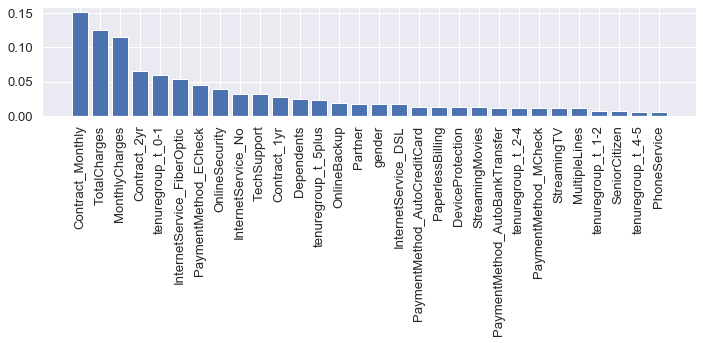

In [299]:
# List Feature Importances
feature_importance = pd.DataFrame({"feature": list(X_train_rf.columns),
                                    "importance":best_rf_model.feature_importances_}).sort_values("importance", ascending=False)
plt.figure(figsize=(10,5))
plt.bar(x="feature", height="importance", data=feature_importance)
plt.xticks(feature_importance["feature"].tolist(), rotation=90)
plt.tight_layout()

feature_importance.head(10)

In [ ]:
Optimization terminated successfully.
         Current function value: 0.451591
         Iterations 7
Summary: 
                                 Results: Logit
===============================================================================
Model:                   Logit                 Pseudo R-squared:      0.348    
Dependent Variable:      Churn                 AIC:                   7021.4669
Date:                    2020-07-26 13:10      BIC:                   7091.0239
No. Observations:        7752                  Log-Likelihood:        -3500.7  
Df Model:                9                     LL-Null:               -5373.3  
Df Residuals:            7742                  LLR p-value:           0.0000   
Converged:               1.0000                Scale:                 1.0000   
No. Iterations:          7.0000                                                
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------
PaymentMethod_MCheck           -2.1268   0.1218 -17.4577 0.0000 -2.3656 -1.8880
tenuregroup_t_0-1               1.2567   0.0727  17.2745 0.0000  1.1141  1.3993
PaymentMethod_ECheck           -1.4472   0.1103 -13.1191 0.0000 -1.6634 -1.2310
TechSupport                    -0.7602   0.0809  -9.4018 0.0000 -0.9187 -0.6017
MonthlyCharges                  0.8673   0.0388  22.3249 0.0000  0.7911  0.9434
Contract_Monthly                1.9886   0.1045  19.0303 0.0000  1.7838  2.1934
OnlineSecurity                 -0.9228   0.0786 -11.7439 0.0000 -1.0768 -0.7688
PaymentMethod_AutoBankTransfer -2.2046   0.1179 -18.6938 0.0000 -2.4357 -1.9734
PaymentMethod_AutoCreditCard   -2.3082   0.1209 -19.0883 0.0000 -2.5452 -2.0712
Contract_1yr                    0.6547   0.1210   5.4130 0.0000  0.4177  0.8918
===============================================================================

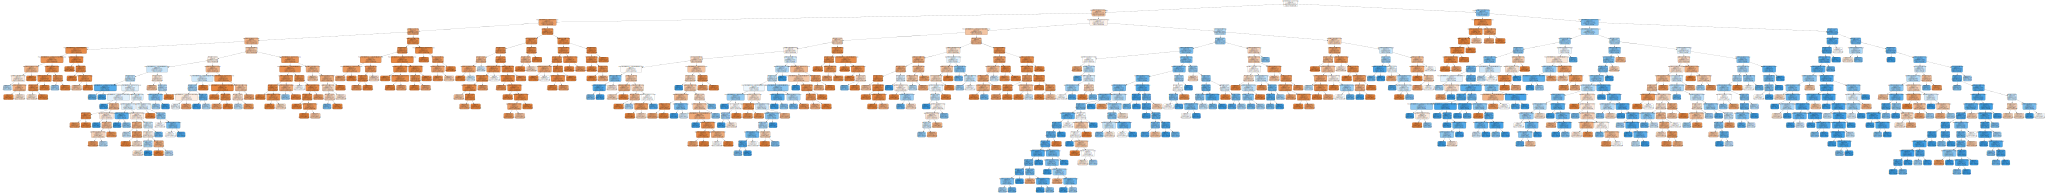

In [101]:
# Pull out one tree from the forest for visualization
est_tree = best_rf_model.estimators_[5]

graph = Source(tree.export_graphviz(est_tree,out_file=None,
                                        rounded=True,proportion = False,
                                        feature_names = X_train_rf.columns.tolist(), 
                                        precision  = 2,
                                        class_names=["Not churn","Churn"],
                                        filled = True                         
                                       )
                  )

display(graph)

In [110]:
model_comparison.sort_values(by=["RecallScore", "AccuracyScore", "F1Score"], ascending=False) 
#Recall scores are generally more focused than Precision Scores, to reduce false negatives on customers churning.

ModelName  AccuracyScore  RecallScore  \
4                      Random Forest HyperTuned       0.807534     0.829140   
3                         Random Forest Default       0.789990     0.797694   
1     Logistic Regression Model - DefaultParams       0.798246     0.796646   
2  Logistic Regression Hyperparameter Optimized       0.881613     0.745283   
0                                Dummy Baseline       0.737081     0.000000   

   PrecisionScore   F1Score  AreaUnderCurve  
4        0.790210  0.809207        0.807863  
3        0.780513  0.789010        0.790107  
1        0.794148  0.795395        0.798221  
2        0.826744  0.783903        0.796930  
0        0.000000  0.000000        0.500000

# Final Conclusions on Models:

In [166]:
best_df = pd.DataFrame(columns=["PerfParam", "BestParamVal", "Model"])

best_recall_score = model_comparison["RecallScore"].max()
best_recall_score_model = model_comparison[model_comparison["RecallScore"]==best_recall_score]["ModelName"].tolist()
best_df = best_df.append([{"PerfParam":"RecallScore", 
                           "BestParamVal":best_recall_score, 
                           "Model":best_recall_score_model[0]}], 
                         ignore_index=True)

best_f1_score = model_comparison["F1Score"].max()
best_f1_score_model = model_comparison[model_comparison["F1Score"]==best_f1_score]["ModelName"].tolist()
best_df = best_df.append([{"PerfParam":"F1Score", 
                           "BestParamVal":best_f1_score, 
                           "Model":best_f1_score_model[0]}], 
                         ignore_index=True)

best_accuracy_score = model_comparison["AccuracyScore"].max()
best_accuracy_score_model = model_comparison[model_comparison["AccuracyScore"]==best_accuracy_score]["ModelName"].tolist()
best_df = best_df.append([{"PerfParam":"AccuracyScore", 
                           "BestParamVal":best_accuracy_score, 
                           "Model":best_accuracy_score_model[0]}], 
                         ignore_index=True)

best_auc_score = model_comparison["AreaUnderCurve"].max()
best_auc_score_model = model_comparison[model_comparison["AreaUnderCurve"]==best_auc_score]["ModelName"].tolist()
best_df = best_df.append([{"PerfParam":"AreaUnderCurve", 
                           "BestParamVal":best_auc_score, 
                           "Model":best_auc_score_model[0]}], 
                         ignore_index=True)

best_precision_score = model_comparison["PrecisionScore"].max()
best_precision_score_model = model_comparison[model_comparison["PrecisionScore"]==best_precision_score]["ModelName"].tolist()
best_df = best_df.append([{"PerfParam":"PrecisionScore", 
                           "BestParamVal":best_precision_score, 
                           "Model":best_precision_score_model[0]}], 
                         ignore_index=True)


print("\033[1mFinal Model Performance Assessments: \033[0;0m")
print(f"Best Recall score is for \033[1m {best_recall_score_model[0]}\033[0;0m with \033[1m{best_recall_score :.2%}\033[0;0m")
print(f"Best F1 score is for \033[1m{best_f1_score_model[0]}\033[0;0m with \033[1m{best_f1_score :.2%}\033[0;0m")
print(f"Best accuracy score is for \033[1m{best_accuracy_score_model[0]}\033[0;0m with \033[1m{best_accuracy_score :.2%}\033[0;0m")
print(f"Best AUC score is for \033[1m {best_auc_score_model[0]}\033[0;0m with \033[1m{best_auc_score :.2%}\033[0;0m")
print(f"Best Precision score is for \033[1m {best_precision_score_model[0]}\033[0;0m with \033[1m{best_precision_score :.2%}\033[0;0m")

best_df

Final Model Performance Assessments: 
Best Recall score is for  Random Forest HyperTuned with 82.91%
Best F1 score is for Random Forest HyperTuned with 80.92%
Best accuracy score is for Logistic Regression Hyperparameter Optimized with 88.16%
Best AUC score is for  Random Forest HyperTuned with 80.79%
Best Precision score is for  Logistic Regression Hyperparameter Optimized with 82.67%


PerfParam  BestParamVal                                         Model
0     RecallScore      0.829140                      Random Forest HyperTuned
1         F1Score      0.809207                      Random Forest HyperTuned
2   AccuracyScore      0.881613  Logistic Regression Hyperparameter Optimized
3  AreaUnderCurve      0.807863                      Random Forest HyperTuned
4  PrecisionScore      0.826744  Logistic Regression Hyperparameter Optimized

In [222]:
import prince

#tel = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
tel = original_telecom.copy(deep=True)
cols = [col for col in tel.columns if col not in ["customerID"] + ["Churn"] + ["tenuregroup"]]
df = tel[cols]

famd = prince.FAMD(n_components = 19,
                  n_iter=3,
                  copy=True,
                  check_input=True,
                  engine="auto",
                  random_state=0)
famd = famd.fit(df)

In [212]:
#famd.row_coordinates(df)
#famd

In [223]:
import prince

#tel = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
tel = original_telecom.copy(deep=True)
cols = [col for col in tel.columns if col not in ["customerID"] + ["Churn"] + ["tenuregroup"]]
df = tel[cols]

famd = prince.FAMD(n_components = 19,
                  n_iter=3,
                  copy=True,
                  check_input=True,
                  engine="auto",
                  random_state=0)
famd = famd.fit(df)
ax = famd.plot_row_coordinates(
...     df,
...     ax=None,
...     figsize=(10, 10),
...     x_component=0,
...     y_component=1,
...     labels=df.index,
...     color_labels=['Churn {}'.format(t) for t in tel['Churn']],
...     ellipse_outline=False,
...     ellipse_fill=True,
...     show_points=False
... )

No handles with labels found to put in legend.


ValueError: Image size of 346976x449701 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x720 with 1 Axes>

[[ 5.03703704e-01  1.96078431e-01  6.84967320e-01  3.45969499e-01
   9.25054466e-01  6.80174292e-01  5.48148148e-01  6.74509804e-01
   6.86274510e-01  5.72113290e-01  7.09803922e-01  7.17647059e-01
   6.84531590e-01  1.39869281e-01  3.88235294e-01  6.11764706e-01
  -1.27675648e-15  3.38562092e-01  4.20915033e-01  2.40522876e-01
   3.22440087e-01  3.10675381e-01  2.86274510e-01  8.06100218e-02
  -1.16573418e-15  4.35729847e-04  2.44880174e-01  2.67538126e-01
   4.87145969e-01  1.02991849e+00  8.00589579e-01  1.25480374e+00]
 [ 4.97872340e-01  2.16666667e-01  3.20567376e-01  1.81560284e-01
   9.12765957e-01  3.69503546e-01  2.07092199e-01  2.69503546e-01
   2.60283688e-01  2.06382979e-01  3.70567376e-01  3.71985816e-01
   7.11347518e-01  4.97517730e-01  4.00000000e-01  6.00000000e-01
  -1.66533454e-15  6.34751773e-02  1.09929078e-02  9.25531915e-01
   1.37588652e-01  1.33333333e-01  5.46808511e-01  1.82269504e-01
   5.64893617e-01  2.53191489e-01  1.78723404e-01  3.19148936e-03
  -2.7755

ValueError: x and y must be the same size

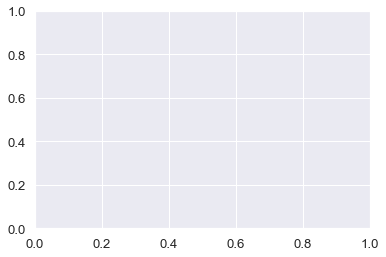

In [196]:
from sklearn.cluster import KMeans
cols = [col for col in telecom.columns if col not in ["customerID"]]
cols_x = [col for col in cols if col not in ["Churn"]]

df = telecom[cols]
  
kmeans = KMeans(n_clusters=3).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df[cols_x], df["Churn"], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [234]:
bi_cs = tel.nunique()[tel.nunique() == 2].keys()
dat_rad = tel[bi_cs]

data_frame = tel[tel["Churn"] == "Yes"] 
data_frame_x = data_frame[bi_cs].sum().reset_index()
data_frame_x.columns  = ["feature","yes"]
data_frame.shape[0]

1869

In [235]:
bi_cs = tel.nunique()[tel.nunique() == 2].keys()
dat_rad = tel[bi_cs]

data_frame = tel[tel["Churn"] == "Yes"] 
data_frame_x = data_frame[bi_cs].sum().reset_index()
data_frame_x.columns  = ["feature","yes"]
#data_frame_x["no"] = data_frame.shape[0]  - data_frame_x["yes"]
data_frame_x  = data_frame_x[data_frame_x["feature"] != "Churn"]

#count of 1's(yes)
trace1 = go.Scatterpolar(r = data_frame_x["yes"].values.tolist(),
 theta = data_frame_x["feature"].tolist(),
 fill  = "toself",name = "count of 1's",
 mode = "markers+lines",
 marker = dict(size = 5)
)

go.Figure(data=trace1)
#count of 0's(No)
#trace2 = go.Scatterpolar(r = data_frame_x["no"].values.tolist(),
# theta = data_frame_x["feature"].tolist(),
# fill  = "toself",name = "count of 0's",
# mode = "markers+lines",
# marker = dict(size = 5)
#) 

NameError: name 'go' is not defined

In [236]:
y_score = cv_model.decision_function(X_test)

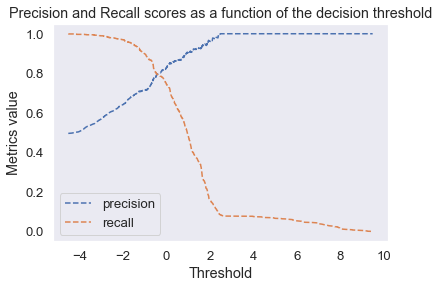

In [241]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plt.plot(thresholds, precision[:len(precision)-1], label='precision', ls = 'dashed') 
plt.plot(thresholds, recall[:len(recall)-1], label='recall', ls = 'dashed') 
plt.legend() 
plt.title('Precision and Recall scores as a function of the decision threshold') 
plt.xlabel('Threshold')
plt.ylabel('Metrics value')
plt.grid()

In [ ]:
features = telecom.columns.tolist()
#features.remove("customerID")
features.remove("Churn")

x = telecom_std.loc[:,features].values
y = telecom_std.loc[:,"Churn"].values

x = StandardScaler().fit_transform(x)
x_std = pd.DataFrame(x).replace(np.nan, 0, regex=True) # remove all NaN entries before sending to StandardScaler


# Get covariance matrix
#Perform eigendecomposition on covariance matrix
cov_mat = np.cov(x_std.T)
print('NumPy covariance matrix: \n%s' %np.cov(x_std.T))

eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)
print(len(eig_vals))

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])
    
    
eig_vals_sorted = []
eig_pairs_sorted_asc = sorted(eig_pairs,key=lambda l:l[0], reverse=True)
for i in eig_pairs_sorted_asc:
    eig_vals_sorted.append(i[0])

print(eig_vals)

# Check with components of 10 and work down based on Scree Plots
n_comp = 15
pca = PCA(n_components = n_comp)
principalComponents = pca.fit_transform(x_std)

columns = []
for i in range(1,n_comp+1): #For PC1 to PC20
    columns.append("PC"+str(i))
    
principaldf = pd.DataFrame(data = principalComponents, columns = columns)
targetdf = telecom[["Churn"]]
newdf = pd.concat([principaldf, targetdf], axis = 1)

percent_var = np.round(pca.explained_variance_ratio_*100, decimals =2)
print(percent_var)
columns = columns

fig, ax = plt.subplots(figsize = (10,10))
ax1 = plt.bar(x=range(1,n_comp+1), height = percent_var, tick_label=columns)
plt.ylabel("Percentage Variance of Principal Components")
plt.xlabel("Principal Components")

ax2 = ax.twinx()
#plt.line(ax.get_xticks(), percent_var, linestyle="-", marker="o")
lineplotdf = pd.DataFrame(percent_var)
ax2.plot(ax.get_xticks(), lineplotdf, linestyle="-", marker="o")

plt.title("Total Percentage Variance Explained Plot")
plt.show()

columns = [] # columns for Scree Plot
x_range = len(eig_vals_sorted)+1
for i in range(1, x_range): #For PC1 to PC20
    columns.append("PC"+str(i))
    
fig, ax = plt.subplots(figsize = (10,10))
ax1 = plt.bar(x=range(1,x_range), height = eig_vals_sorted, tick_label=columns)
plt.ylabel("EigenValues")
plt.xlabel("Principal Components")

ax2 = ax.twinx()
#plt.line(ax.get_xticks(), percent_var, linestyle="-", marker="o")
lineplotdf = pd.DataFrame(eig_vals_sorted)
ax2.plot(ax.get_xticks(), lineplotdf, linestyle="-", marker="o")

plt.title("Scree Plot")
plt.tight_layout()
plt.show()


print(f"Percentage Variance by Principal Component: {percent_var} \n")
sump = 0
print("Cumulative Percentage Variance by Principal Component:\n")
for i in range(0,n_comp):  # Get Cumulative Percent Variance by PC 
    sump = sump + percent_var[i]
    print(f"PC{i+1}", ": ", sump)

In [2]:
import prince
# Notebook settings
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 100)
warnings.simplefilter(action='ignore', category=FutureWarning)
telecom = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
telecom.head()
# Some categorical feature levels can be refined for a cleaner classification between catergory levels

# 1. Change "No internet service" to "No"
l_reduce_nointernet = ["OnlineSecurity", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", \
             "StreamingTV", "StreamingMovies"]

for cols in l_reduce_nointernet:
    telecom[cols] = telecom[cols].replace({"No internet service" : "No"})

# 2. Change "No phone service" to "No"
telecom["MultipleLines"] = telecom["MultipleLines"].replace({"No phone service": "No"})

# 3. Shorten PaymentMethod details
telecom["PaymentMethod"] = telecom["PaymentMethod"].replace({"Electronic check": "ECheck",
                                                             "Mailed check":"MCheck",
                                                             "Bank transfer (automatic)":"AutoBankTransfer",
                                                             "Credit card (automatic)":"AutoCreditCard"})

# 4. Shorten InternetService details
telecom["InternetService"] = telecom["InternetService"].replace({"Fiber optic" :"FiberOptic"})

#5. Shorten Contract details
telecom["Contract"] = telecom["Contract"].replace({"Month-to-month" :"Monthly", "One year":"1yr", "Two year":"2yr"})
# Convert Tenure into categorical feature levels
def tenure_conversion(df):
    if df["tenure"] <= 12:
        return "t_0-1"
    if (df["tenure"] > 12) & (df["tenure"] <= 24):
        return "t_1-2"
    if (df["tenure"] > 24) & (df["tenure"] <= 48):
        return "t_2-4"
    if (df["tenure"] > 48) & (df["tenure"] <= 60):
        return "t_4-5"
    if df["tenure"] > 60:
        return "t_5plus"
telecom["tenuregroup"] = telecom.apply(lambda x: tenure_conversion(x), axis=1)

telecom = telecom.drop(columns=["customerID", "tenure"])

#tel = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
tel = telecom.copy(deep=True)
cols = [col for col in tel.columns if col not in ["customerID"] + ["Churn"] + ["tenuregroup"]]
df = tel[cols]


In [3]:

famd = prince.FAMD(n_components = 19,
                  n_iter=3,
                  copy=True,
                  check_input=True,
                  engine="auto",
                  random_state=0)
famd = famd.fit(df)

<BarContainer object of 19 artists>

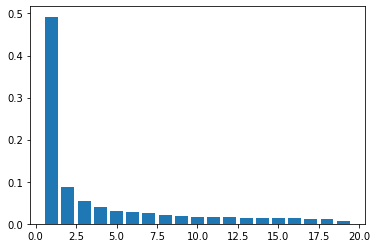

In [10]:
plt.bar(x=range(1,20), height=famd.explained_inertia_)

In [12]:
famd.column_correlations(tel)

0         1         2         3         4   \
Contract_1yr        -0.265548  0.102352  0.225139  0.029460  0.013926   
Contract_2yr        -0.426457  0.160765  0.514006 -0.102084 -0.019694   
Contract_Monthly     0.583553 -0.221823 -0.625750  0.063638  0.005539   
Dependents_No        0.357892 -0.012765 -0.587876  0.425606 -0.015843   
Dependents_Yes      -0.357892  0.012765  0.587876 -0.425606  0.015843   
...                       ...       ...       ...       ...       ...   
TotalCharges_999.45  0.015774 -0.007211 -0.015880 -0.005743 -0.012759   
TotalCharges_999.8   0.008416  0.002935 -0.006660 -0.005510  0.011642   
TotalCharges_999.9  -0.000169  0.009566 -0.013469  0.013169 -0.011216   
gender_Female       -0.012350  0.024209 -0.014836  0.009249 -0.997553   
gender_Male          0.012350 -0.024209  0.014836 -0.009249  0.997553   

                           5         6         7         8         9   \
Contract_1yr        -0.100368 -0.082996 -0.150868 -0.255157 -0.019703   
Contract_2yr        -0.259768 -0.034934 -0.264639 -0.066441  0.064691   
Contract_Monthly     0.305276  0.097870  0.350746  0.265690 -0.039482   
Dependents_No       -0.369913  0.023189 -0.063584 -0.062910 -0.095126   
Dependents_Yes       0.369913 -0.023189  0.063584  0.062910  0.095126   
...                       ...       ...       ...       ...       ...   
TotalCharges_999.45 -0.007921  0.012703 -0.008810  0.006205 -0.000646   
TotalCharges_999.8   0.011875  0.007306  0.006908 -0.021959  0.002445   
TotalCharges_999.9   0.005526 -0.000305  0.005266 -0.014305 -0.009630   
gender_Female        0.031844 -0.049051  0.003635 -0.001314 -0.007909   
gender_Male         -0.031844  0.049051 -0.003635  0.001314  0.007909   

                           10        11        12        13        14  \
Contract_1yr         0.372510  0.037962  0.048259  0.802293  0.055730   
Contract_2yr        -0.098578 -0.077124 -0.058738 -0.471882 -0.027670   
Contract_Monthly    -0.219826  0.035239  0.011022 -0.250399 -0.021784   
Dependents_No        0.108514 -0.245747 -0.431826 -0.004576  0.082389   
Dependents_Yes      -0.108514  0.245747  0.431826  0.004576 -0.082389   
...                       ...       ...       ...       ...       ...   
TotalCharges_999.45 -0.005743  0.003443  0.007931 -0.002223 -0.000669   
TotalCharges_999.8   0.009551 -0.004475 -0.018191 -0.011706 -0.030220   
TotalCharges_999.9  -0.017823  0.021959 -0.013794  0.002041 -0.027302   
gender_Female       -0.010376 -0.000488  0.011895  0.011577 -0.001052   
gender_Male          0.010376  0.000488 -0.011895 -0.011577  0.001052   

                           15        16        17        18  
Contract_1yr         0.142199  0.017682 -0.132752  0.036164  
Contract_2yr        -0.169094 -0.133377  0.467332  0.095459  
Contract_Monthly     0.029054  0.100158 -0.293057 -0.111594  
Dependents_No       -0.132954  0.153730  0.000575 -0.031751  
Dependents_Yes       0.132954 -0.153730 -0.000575  0.031751  
...                       ...       ...       ...       ...  
TotalCharges_999.45  0.004603  0.019960 -0.007269  0.017170  
TotalCharges_999.8  -0.012925  0.003720 -0.021144 -0.003558  
TotalCharges_999.9   0.008051 -0.002221  0.010138 -0.006787  
gender_Female       -0.004136  0.002521  0.000044  0.002105  
gender_Male          0.004136 -0.002521 -0.000044 -0.002105  

[6567 rows x 19 columns]

In [25]:
famd_df = pd.DataFrame(columns=["name", "eigenvalues"])
for name, fa in sorted(famd.partial_factor_analysis_.items()):  # doctest: +ELLIPSIS
        famd_df = famd_df.append([{"name":name, "eigenvalues":fa.eigenvalues_}], ignore_index=False)
        print('{} eigenvalues: {}'.format(name, fa.eigenvalues_))


Categorical eigenvalues: [0.27562193535720364, 0.19766862533145346, 0.14926324863594717, 0.09097835462214361, 0.08610427507177891, 0.08262310727347179, 0.0780586294815369, 0.07332424080884978, 0.07087225459598351, 0.06900954056592253, 0.06771346930144331, 0.06605328887122813, 0.06521681870304721, 0.06408939948713811, 0.06383489248831166, 0.06335783717215965, 0.06326354882571802, 0.06288486425364001, 0.06262478567542125]
Numerical eigenvalues: [1.2201733385762719, 0.779826661423729]


In [36]:
famd_cat_eig = famd_df[famd_df["name"]=="Categorical"]["eigenvalues"].values.tolist()
famd_num_eig = famd_df[famd_df["name"]=="Numerical"]["eigenvalues"].values.tolist()

[[1.2201733385762719, 0.779826661423729]]

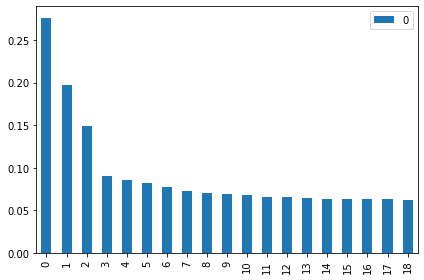

In [93]:
famd_cat_eig = pd.DataFrame(famd_cat_eig).transpose()
famd_num_eig = pd.DataFrame(famd_num_eig).transpose()

famd_cat_eig.plot(kind="bar")
#plt.title=("Categorical Scree Plot")
plt.tight_layout()

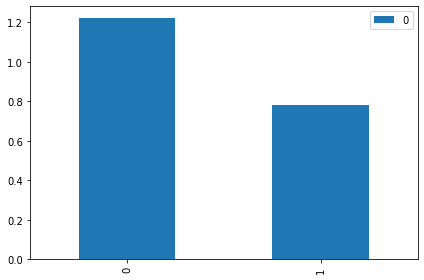

In [94]:
famd_num_eig.plot(kind="bar")
plt.tight_layout()

In [111]:
famd.

KeyError: "None of [Index(['gender', 'DeviceProtection', 'Contract', 'OnlineBackup', 'StreamingTV',\n       'InternetService', 'Dependents', 'PhoneService', 'StreamingMovies',\n       'OnlineSecurity', 'PaperlessBilling', 'PaymentMethod', 'MultipleLines',\n       'Partner', 'TechSupport', 'TotalCharges'],\n      dtype='object')] are in the [columns]"

In [127]:
name, fa = famd.partial_factor_analysis_.items()

In [137]:
famd.plot_row_coordinates

<bound method PCA.plot_row_coordinates of FAMD(n_components=19, random_state=0)>